# Classification Models

## Define Functions for Classification Models

In [1]:
def get_scores(y_test, y_hat_test):
    scores_dict = {'precision':round(precision_score(y_test, y_hat_test, average='weighted'),2),
           'recall': round(recall_score(y_test, y_hat_test, average='weighted'),2),
           'accuracy': round(accuracy_score(y_test, y_hat_test),2),
           'f1': round(f1_score(y_test, y_hat_test,average='weighted'),2)}
    return scores_dict

In [2]:
def run_model(model, X_train, y_train, X_test, y_test):
    
    # fit model
    model.fit(X_train, y_train)
    
    # make predictions
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    # print classification report
    print(f'Training accuracy score: {round(accuracy_score(y_train,y_hat_train),2)}')
    print(classification_report(y_test, y_hat_test, target_names=class_names))
    
    # plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title('Confusion Matrix')
    disp = plot_confusion_matrix(model, X_test, y_test, ax = ax,
                                 display_labels = class_names,
                                 normalize='true', 
                                 cmap='GnBu')
    plt.grid(False)
    
    return get_scores(y_test, y_hat_test)

In [3]:
def plot_top_10_features(model, model_name):
    feature_names = X_train.columns
    feature_imports = model.feature_importances_
    most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], 
                                     columns=["Feature", "Importance"]).nlargest(10, "Importance")
    most_imp_features.sort_values(by="Importance", inplace=True)

    plt.figure(figsize=(12,5))
    plt.barh(range(len(most_imp_features)), most_imp_features.Importance, 
             align='center', alpha=0.8, color='teal')
    plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=12)
    plt.xlabel('Importance')
    plt.title(f'Most Important Features - {model_name}', fontsize=12)
    plt.show()

In [4]:
def cross_val_classifier(clf, X, y, cv=5):
    scoring = ['accuracy','precision','recall','f1']
    scores = cross_validate(estimator=clf, X=X, y=y, 
                            cv=cv, scoring=scoring, return_train_score=True)
    
    avg_scores = []
    for key in scores.keys():
        mean = scores[key].mean()
        avg_scores.append(mean)

    avg_score_dict = dict(zip(scores.keys(),avg_scores))
    return avg_score_dict


# Can we predict which zipcode is next to experience explosive growth?

To answer this question, we will take the average airbnb features in 2019 and see if we can build a model that classifies each zipcode as high, low or moderate growth in 2020.

## Load Libraries and Dataframe

In [5]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score 
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import warnings
import pickle
warnings.filterwarnings("ignore")

In [6]:
airbnb_class_df = pd.read_csv("large_clean_data/airbnb_model_data_clean.csv", index_col=0)
zillow_class_df = pd.read_csv("cleaned_data/zillow_model_data_clean.csv", index_col=0)

In [7]:
airbnb_class_df.head()

last_scraped    id  host_id  host_is_superhost  zipcode   latitude  \
151947   2015-06-29  6422    12172                  0  37206.0  36.173151   
87       2015-10-03  6422    12172                  0  37206.0  36.173151   
205880   2016-09-06  6422    12172                  1  37206.0  36.173151   
209372   2017-09-14  6422    12172                  0  37206.0  36.173151   
113349   2018-04-14  6422    12172                  1  37206.0  36.173151   

        longitude  accommodates  bathrooms  beds  ...  neighborhood_Downtown  \
151947 -86.735813             2        1.0   1.0  ...                      0   
87     -86.735813             2        1.0   1.0  ...                      0   
205880 -86.735813             2        1.0   2.0  ...                      0   
209372 -86.735813             2        1.0   2.0  ...                      0   
113349 -86.735813             2        1.0   3.0  ...                      0   

        neighborhood_East_Nashville  neighborhood_Madison  \
151947                            1                     0   
87                                1                     0   
205880                            1                     0   
209372                            1                     0   
113349                            1                     0   

        neighborhood_Midtown  neighborhood_North_Nashville  \
151947                     0                             0   
87                         0                             0   
205880                     0                             0   
209372                     0                             0   
113349                     0                             0   

        neighborhood_Parkwood  neighborhood_South_Nashville  \
151947                      0                             0   
87                          0                             0   
205880                      0                             0   
209372                      0                             0   
113349                      0                             0   

        neighborhood_Southeast_Nashville  neighborhood_West_Nashville  \
151947                                 0                            0   
87                                     0                            0   
205880                                 0                            0   
209372                                 0                            0   
113349                                 0                            0   

        neighborhood_Whites_Creek  
151947                          0  
87                              0  
205880                          0  
209372                          0  
113349                          0  

[5 rows x 49 columns]

In [8]:
zillow_class_df.head()

37013     37211     37064     37027     37221     37209  \
index                                                                    
1996-01-01  109670.0  106734.0  185356.0  278097.0  147818.0  109565.0   
1996-02-01  110113.0  107099.0  185830.0  278949.0  148278.0  109833.0   
1996-03-01  110502.0  107465.0  186363.0  280102.0  148776.0  110119.0   
1996-04-01  111295.0  108224.0  187234.0  282052.0  149757.0  110736.0   
1996-05-01  112128.0  108963.0  188162.0  283765.0  150615.0  111338.0   

               37076    37115    37207    37214  ...    37073    37218  \
index                                            ...                     
1996-01-01  111805.0  83431.0  88757.0  90986.0  ...  97999.0  96715.0   
1996-02-01  112174.0  83844.0  88978.0  91382.0  ...  98271.0  96743.0   
1996-03-01  112465.0  84214.0  89205.0  91756.0  ...  98600.0  96824.0   
1996-04-01  113059.0  84939.0  89562.0  92508.0  ...  99234.0  97066.0   
1996-05-01  113683.0  85603.0  90104.0  93240.0  ...  99774.0  97800.0   

               37080     37220  37219     37143     37189  37201  37026  \
index                                                                     
1996-01-01  100882.0  185197.0    NaN  102606.0   99095.0    NaN    NaN   
1996-02-01  100959.0  185138.0    NaN  102595.0   99161.0    NaN    NaN   
1996-03-01  101073.0  185521.0    NaN  102631.0   99564.0    NaN    NaN   
1996-04-01  101279.0  186392.0    NaN  102838.0   99833.0    NaN    NaN   
1996-05-01  101650.0  187482.0    NaN  103283.0  100366.0    NaN    NaN   

            avg_home_value  
index                       
1996-01-01        115807.0  
1996-02-01        116150.0  
1996-03-01        116540.0  
1996-04-01        117300.0  
1996-05-01        118071.0  

[5 rows x 36 columns]

## Add % Increases in Zipcode Prices

In [9]:
zillow_class_df = zillow_class_df.T

In [10]:
zillow_class_df['20_21_inc'] = ((zillow_class_df['2021-02-01']/zillow_class_df['2020-02-01'])-1)*100
zillow_class_df['19_20_inc'] = ((zillow_class_df['2020-02-01']/zillow_class_df['2019-02-01'])-1)*100
zillow_class_df['CAGR'] = ((zillow_class_df['2021-02-01']/zillow_class_df['2016-02-01'])**(1/5)-1)*100

zillow_class_df

index           1996-01-01  1996-02-01  1996-03-01  1996-04-01  1996-05-01  \
37013             109670.0    110113.0    110502.0    111295.0    112128.0   
37211             106734.0    107099.0    107465.0    108224.0    108963.0   
37064             185356.0    185830.0    186363.0    187234.0    188162.0   
37027             278097.0    278949.0    280102.0    282052.0    283765.0   
37221             147818.0    148278.0    148776.0    149757.0    150615.0   
37209             109565.0    109833.0    110119.0    110736.0    111338.0   
37076             111805.0    112174.0    112465.0    113059.0    113683.0   
37115              83431.0     83844.0     84214.0     84939.0     85603.0   
37207              88757.0     88978.0     89205.0     89562.0     90104.0   
37214              90986.0     91382.0     91756.0     92508.0     93240.0   
37203             147659.0    148063.0    148532.0    149409.0    151089.0   
37217              87304.0     87676.0     87963.0     88595.0     89211.0   
37206              88846.0     89146.0     89304.0     89650.0     90189.0   
37072             113466.0    113699.0    113990.0    114774.0    115602.0   
37067             223323.0    223362.0    223813.0    224668.0    225691.0   
37086             102888.0    102924.0    103113.0    103450.0    103889.0   
37205             224625.0    225404.0    226360.0    228334.0    230387.0   
37215             262194.0    262701.0    263324.0    264787.0    266371.0   
37208                  NaN         NaN         NaN         NaN         NaN   
37138             112877.0    113258.0    113656.0    114436.0    115214.0   
37216              88121.0     88466.0     88751.0     89336.0     89922.0   
37212             124073.0    124773.0    125195.0    126309.0    127568.0   
37015              77069.0     77404.0     77695.0     78275.0     78985.0   
37210              79652.0     80214.0     80614.0     81281.0     81785.0   
37204             154906.0    155616.0    156426.0    158037.0    159922.0   
37069             224206.0    224165.0    224813.0    225632.0    227047.0   
37073              97999.0     98271.0     98600.0     99234.0     99774.0   
37218              96715.0     96743.0     96824.0     97066.0     97800.0   
37080             100882.0    100959.0    101073.0    101279.0    101650.0   
37220             185197.0    185138.0    185521.0    186392.0    187482.0   
37219                  NaN         NaN         NaN         NaN         NaN   
37143             102606.0    102595.0    102631.0    102838.0    103283.0   
37189              99095.0     99161.0     99564.0     99833.0    100366.0   
37201                  NaN         NaN         NaN         NaN         NaN   
37026                  NaN         NaN         NaN         NaN         NaN   
avg_home_value    115807.0    116150.0    116540.0    117300.0    118071.0   

index           1996-06-01  1996-07-01  1996-08-01  1996-09-01  1996-10-01  \
37013             112982.0    113867.0    114736.0    115551.0    116199.0   
37211             109639.0    110367.0    111082.0    111876.0    112514.0   
37064             189085.0    190103.0    190882.0    191703.0    192556.0   
37027             285161.0    286776.0    288433.0    289973.0    291356.0   
37221             151485.0    152349.0    153349.0    154261.0    155079.0   
37209             112027.0    112493.0    113092.0    113650.0    114305.0   
37076             114306.0    114862.0    115347.0    115830.0    116427.0   
37115              86245.0     86958.0     87665.0     88304.0     88769.0   
37207              90606.0     91224.0     91698.0     92414.0     93066.0   
37214              94038.0     94891.0     95740.0     96499.0     97123.0   
37203             152675.0    154294.0    155215.0    156062.0    156969.0   
37217              89950.0     90695.0     91339.0     91844.0     92218.0   
37206              90906.0     91597.0     92110.0     92627.0     93137.0   
37072             116

In [11]:
# decided to use 20-21 increase as our growth measure
zillow_class_df['20_21_inc'].describe()

count    36.000000
mean      9.823556
std       2.356725
min       3.918521
25%       8.748340
50%       9.864084
75%      11.416112
max      15.356898
Name: 20_21_inc, dtype: float64

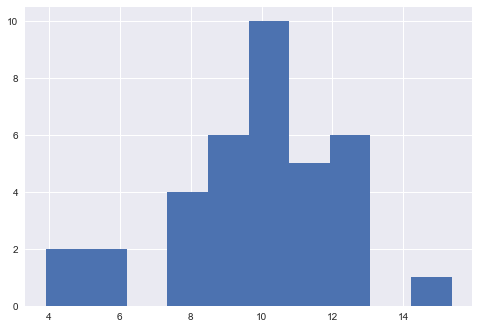

In [12]:
zillow_class_df['20_21_inc'].hist()

In [13]:
def growth_category(x):
    if x < 9:
        return 'low'
    elif x > 11:
        return 'high'
    else:
        return 'moderate'

In [14]:
zillow_class_df['growth'] = zillow_class_df['20_21_inc'].apply(lambda x: growth_category(x))

In [15]:
zillow_class_df['growth'].value_counts()

moderate    14
high        11
low         11
Name: growth, dtype: int64

## Create a dictionary of zipcodes and growth categories

In [16]:
growth_zips = dict(zip(list(zillow_class_df.index),list(zillow_class_df.growth)))

## Create Dataframe of 2019 Airbnb Data by Zipcode

In [17]:
airbnb_class_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233320 entries, 151947 to 99590
Data columns (total 49 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   last_scraped                      233320 non-null  object 
 1   id                                233320 non-null  int64  
 2   host_id                           233320 non-null  int64  
 3   host_is_superhost                 233320 non-null  int64  
 4   zipcode                           233320 non-null  float64
 5   latitude                          233320 non-null  float64
 6   longitude                         233320 non-null  float64
 7   accommodates                      233320 non-null  int64  
 8   bathrooms                         233320 non-null  float64
 9   beds                              233320 non-null  float64
 10  price                             233320 non-null  float64
 11  minimum_nights                    233320 non-nul

In [18]:
airbnb_class_df['last_scraped'] = pd.to_datetime(airbnb_class_df['last_scraped'])
airbnb_class_df.set_index('last_scraped',inplace=True)

In [19]:
# create a datframe with all of the airbnb properties in 2019
airbnb_2019 = airbnb_class_df['2019-01-01':'2020-01-01']
airbnb_2019

id    host_id  host_is_superhost  zipcode   latitude  \
last_scraped                                                               
2019-01-17        6422      12172                  1  37206.0  36.173151   
2019-02-09        6422      12172                  1  37206.0  36.173151   
2019-03-11        6422      12172                  1  37206.0  36.173150   
2019-04-14        6422      12172                  1  37206.0  36.173150   
2019-05-15        6422      12172                  1  37206.0  36.173150   
...                ...        ...                ...      ...        ...   
2019-12-16    40775036  101426897                  1  37204.0  36.131230   
2019-12-16    40777622    6675690                  1  37212.0  36.132270   
2019-12-16    40802632  180346882                  0  37214.0  36.117930   
2019-12-16    40805104  194953121                  0  37214.0  36.221270   
2019-12-16    40819746  317491431                  0  37209.0  36.154090   

              longitude  accommodates  bathrooms  beds   price  ...  \
last_scraped                                                    ...   
2019-01-17   -86.735813             2        1.0   3.0    40.0  ...   
2019-02-09   -86.735813             2        1.0   3.0    40.0  ...   
2019-03-11   -86.735810             2        1.0   3.0    40.0  ...   
2019-04-14   -86.735810             2        1.0   3.0    40.0  ...   
2019-05-15   -86.735810             2        1.0   3.0    40.0  ...   
...                 ...           ...        ...   ...     ...  ...   
2019-12-16   -86.781990            12        5.0  12.0   999.0  ...   
2019-12-16   -86.803380            16        6.0  13.0  1000.0  ...   
2019-12-16   -86.627200             2        1.0   2.0    60.0  ...   
2019-12-16   -86.705510             8        2.0   4.0   555.0  ...   
2019-12-16   -86.826500            10        3.5   6.0   495.0  ...   

              neighborhood_Downtown  neighborhood_East_Nashville  \
last_scraped                                                       
2019-01-17                        0                            1   
2019-02-09                        0                            1   
2019-03-11                        0                            1   
2019-04-14                        0                            1   
2019-05-15                        0                            1   
...                             ...                          ...   
2019-12-16                        0                            0   
2019-12-16                        0                            0   
2019-12-16                        0                            0   
2019-12-16                        0                            0   
2019-12-16                        0                            0   

              neighborhood_Madison  neighborhood_Midtown  \
last_scraped                                               
2019-01-17                       0                     0   
2019-02-09                       0                     0   
2019-03-11                       0                     0   
2019-04-14                       0                     0   
2019-05-15                       0                     0   
...                            ...                   ...   
2019-12-16                       0                     0   
2019-12-16                       0                     1   
2019-12-16                       0                     0   
2019-12-16                       0                     0   
2019-12-16                       0                     0   

              neighborhood_North_Nashville  neighborhood_Parkwood  \
last_scraped                                                        
2019-01-17                               0                      0   
2019-02-09                               0                      0   
2019-03-11                               0                      0   
2019-04-14                               0                      0   
2019-05-15                 

In [20]:
# get the average value of each airbnb by zipcode for 2019
airbnb_2019_zips = airbnb_2019.groupby('zipcode').mean()
airbnb_2019_zips

id       host_id  host_is_superhost   latitude  longitude  \
zipcode                                                                        
37013.0  2.593134e+07  1.317891e+08           0.316306  36.050928 -86.647237   
37015.0  1.636789e+07  7.666481e+07           0.750000  36.233651 -86.906450   
37026.0  3.964250e+07  1.212351e+08           0.000000  36.192810 -86.725560   
37027.0  1.724309e+07  5.352425e+07           0.557971  36.040096 -86.776787   
37064.0  3.055183e+07  4.462003e+07           0.000000  36.002450 -87.019431   
37072.0  2.351091e+07  8.659735e+07           0.441296  36.318876 -86.723207   
37073.0  3.059304e+07  2.291713e+08           0.750000  36.397831 -86.761820   
37076.0  1.876910e+07  7.593386e+07           0.541985  36.180295 -86.597899   
37080.0  2.237210e+07  8.919574e+07           0.255556  36.315329 -86.894608   
37086.0  3.131322e+07  1.239516e+08           0.000000  36.027800 -86.570550   
37115.0  2.114461e+07  6.851679e+07           0.556490  36.258045 -86.711955   
37138.0  2.484385e+07  1.095909e+08           0.312941  36.246973 -86.633440   
37143.0  2.169747e+07  6.013223e+07           0.666667  36.108937 -87.009889   
37189.0  2.506048e+07  9.939680e+07           0.302521  36.272454 -86.821218   
37201.0  2.008333e+07  9.152053e+07           0.566141  36.168688 -86.776788   
37203.0  2.582401e+07  9.975239e+07           0.526471  36.149439 -86.788704   
37204.0  2.207612e+07  9.296115e+07           0.571711  36.122968 -86.781246   
37205.0  2.095167e+07  5.736053e+07           0.469751  36.126272 -86.848891   
37206.0  1.986432e+07  6.158414e+07           0.705916  36.179456 -86.743835   
37207.0  2.317656e+07  7.742507e+07           0.612474  36.200137 -86.768752   
37208.0  2.525956e+07  9.155735e+07           0.551797  36.175882 -86.799873   
37209.0  2.331077e+07  7.901202e+07           0.605634  36.154100 -86.846241   
37210.0  2.390785e+07  8.307252e+07           0.435586  36.144006 -86.751633   
37211.0  2.100555e+07  7.283276e+07           0.544572  36.080504 -86.731850   
37212.0  2.024257e+07  7.913327e+07           0.640845  36.136239 -86.798378   
37213.0  2.972112e+07  9.180951e+07           0.000000  36.171681 -86.768233   
37214.0  2.181930e+07  8.635844e+07           0.496701  36.187490 -86.680220   
37215.0  1.999463e+07  7.060791e+07           0.494505  36.107585 -86.817501   
37216.0  2.082907e+07  6.959543e+07           0.671094  36.210595 -86.727109   
37217.0  2.249004e+07  9.374859e+07           0.529038  36.105579 -86.667199   
37218.0  2.350532e+07  1.190043e+08           0.437500  36.207675 -86.846828   
37219.0  2.321220e+07  9.476882e+07           0.104717  36.164556 -86.781559   
37220.0  1.829886e+07  8.020098e+07           0.574661  36.065195 -86.765682   
37221.0  2.122171e+07  8.389610e+07           0.411079  36.067178 -86.952040   
37222.0  3.872861e+07  4.120760e+07           1.000000  36.077595 -86.725180   
37228.0  3.600320e+07  1.772062e+08           0.647059  36.191519 -86.791481   
37232.0  2.470891e+07  6.114352e+07           0.000000  36.139393 -86.798435   
37243.0  2.999428e+07  1.961405e+07           0.500000  36.166904 -86.782999   

         accommodates  bathrooms      beds       price  minimum_nights  ...  \
zipcode                                                                 ...   
37013.0      4.351670   1.555010  2.469548  125.628684        4.185658  ...   
37015.0      2.000000   1.000000  1.000000   60.833333        2.000000  ...   
37026.0      4.000000   1.000000  2.000000  155.000000        3.000000  ...   
37027.0      3.818841   1.271739  2.224638  101.333333       17.123188  ...   
37064.0      8.000000   3.000000  3.000000  275.000000        2.000000  ...   
37072.0      4.441296   1.438259  2.342105  125.186235        3.135628  ...   
37073.0      6.000000   1.000000  3.166667   80.000000        2.000000  ...   
37076.0      3.882225   1.364776  2.037077   98.631407        9.000000  ...   
37080.0      6.294444   2.18

When we obtain the average value by zipcode this way, we get the average value for each individual airbnb. This causes our categorical variables to represent a percentage of homes instead of a count. For example, we want the number of superhosts (calculated through a monthly average) there were in a zipcode in 2019. We will create a new dataframe that obtains the average monthly numbers to be used at the categorical columns in our model data.

In [21]:
# filter airbnb data to only include 2019 data and groupby zipcode
zipcode_class_df = airbnb_class_df['2019'].groupby('zipcode')
# resample the 2019 zipcode dataframe to be monthly and use a sum for each month instead of an average
zipcode_class_monthly_df = zipcode_class_df.resample('M').sum()

In [22]:
zipcode_class_monthly_df

id      host_id  host_is_superhost    zipcode  \
zipcode last_scraped                                                          
37013.0 2019-01-31    1767116405   8551343029                 26  2850001.0   
        2019-02-28    1755938936   8370096275                 22  2812988.0   
        2019-03-31    1641778473   7743355394                 21  2664936.0   
        2019-04-30    1697418342   7691877521                 20  2627923.0   
        2019-05-31    2159415319  11020522254                 20  3183118.0   
...                          ...          ...                ...        ...   
37232.0 2019-06-30             0            0                  0        0.0   
        2019-07-31             0            0                  0        0.0   
        2019-08-31             0            0                  0        0.0   
        2019-09-30      38474804     58355472                  0    37232.0   
37243.0 2019-01-31      59988556     39228095                  1    74486.0   

                         latitude    longitude  accommodates  bathrooms  \
zipcode last_scraped                                                      
37013.0 2019-01-31    2775.875495 -6672.015945           356      126.0   
        2019-02-28    2739.942842 -6585.435346           346      123.5   
        2019-03-31    2595.740680 -6238.745060           326      116.5   
        2019-04-30    2559.571080 -6151.917140           317      113.5   
        2019-05-31    3100.330060 -7451.688920           398      136.5   
...                           ...          ...           ...        ...   
37232.0 2019-06-30       0.000000     0.000000             0        0.0   
        2019-07-31       0.000000     0.000000             0        0.0   
        2019-08-31       0.000000     0.000000             0        0.0   
        2019-09-30      36.149930   -86.813110             2        2.0   
37243.0 2019-01-31      72.333809  -173.565999            12        5.0   

                       beds    price  ...  neighborhood_Downtown  \
zipcode last_scraped                  ...                          
37013.0 2019-01-31    196.0  10159.0  ...                      0   
        2019-02-28    191.0  10685.0  ...                      0   
        2019-03-31    182.0  10307.0  ...                      0   
        2019-04-30    180.0  10097.0  ...                      0   
        2019-05-31    232.0  11849.0  ...                      0   
...                     ...      ...  ...                    ...   
37232.0 2019-06-30      0.0      0.0  ...                      0   
        2019-07-31      0.0      0.0  ...                      0   
        2019-08-31      0.0      0.0  ...                      0   
        2019-09-30      1.0    150.0  ...                      0   
37243.0 2019-01-31      8.0   1189.0  ...                      2   

                      neighborhood_East_Nashville  neighborhood_Madison  \
zipcode last_scraped                                                      
37013.0 2019-01-31                              0                     0   
        2019-02-28                              0                     0   
        2019-03-31                              0                     0   
        2019-04-30                              0                     0   
        2019-05-31                              0                     0   
...                                           ...                   ...   
37232.0 2019-06-30                              0                     0   
        2019-07-31                              0                     0   
        2019-08-31                              0                     0   
        2019-09-30                              0                     0   
37243.0 2019-01-31                              0                     0   

                      neighborhood_Midtown  neighborhood_North_Nashville  \
zipcode last_scraped                                                       
37013.0 2019-

In [23]:
# drop the duplicate zipcode column and reset the index
zipcode_class_monthly_df.drop(columns='zipcode', inplace=True)
zipcode_class_monthly_df.reset_index(inplace=True)

# convert last_scraped back to datetime and set the index again
zipcode_class_monthly_df['last_scraped'] = pd.to_datetime(zipcode_class_monthly_df['last_scraped'])
zipcode_class_monthly_df.set_index('last_scraped',inplace=True)

# groupby zipcode again and then resample to be annual, so we can get an average value for each zipcode for the full 2019 year
zipcode_class_monthly_df_grp = zipcode_class_monthly_df.groupby('zipcode')
zipcode_class_ann_df = zipcode_class_monthly_df_grp.resample('A').mean()

zipcode_class_ann_df

zipcode            id       host_id  host_is_superhost  \
zipcode last_scraped                                                           
37013.0 2019-12-31    37013.0  2.199842e+09  1.118011e+10          26.833333   
37015.0 2019-12-31    37015.0  1.636789e+07  7.666481e+07           0.750000   
37026.0 2019-12-31    37026.0  3.964250e+07  1.212351e+08           0.000000   
37027.0 2019-12-31    37027.0  1.982956e+08  6.155288e+08           6.416667   
37064.0 2019-12-31    37064.0  3.055183e+07  4.462003e+07           0.000000   
37072.0 2019-12-31    37072.0  9.678657e+08  3.564924e+09          18.166667   
37073.0 2019-12-31    37073.0  3.059304e+07  2.291713e+08           0.750000   
37076.0 2019-12-31    37076.0  1.434272e+09  5.802612e+09          41.416667   
37080.0 2019-12-31    37080.0  3.355815e+08  1.337936e+09           3.833333   
37086.0 2019-12-31    37086.0  3.131322e+07  1.239516e+08           0.000000   
37115.0 2019-12-31    37115.0  1.466026e+09  4.750497e+09          38.583333   
37138.0 2019-12-31    37138.0  8.798862e+08  3.881345e+09          11.083333   
37143.0 2019-12-31    37143.0  5.966805e+07  1.653636e+08           1.833333   
37189.0 2019-12-31    37189.0  2.485165e+08  9.856849e+08           3.000000   
37201.0 2019-12-31    37201.0  4.567284e+09  2.081329e+10         128.750000   
37203.0 2019-12-31    37203.0  2.841286e+10  1.097526e+11         579.250000   
37204.0 2019-12-31    37204.0  6.516135e+09  2.743903e+10         168.750000   
37205.0 2019-12-31    37205.0  2.453091e+09  6.715962e+09          55.000000   
37206.0 2019-12-31    37206.0  1.737632e+10  5.387073e+10         617.500000   
37207.0 2019-12-31    37207.0  9.444447e+09  3.155071e+10         249.583333   
37208.0 2019-12-31    37208.0  1.200882e+10  4.352789e+10         262.333333   
37209.0 2019-12-31    37209.0  1.006831e+10  3.412661e+10         261.583333   
37210.0 2019-12-31    37210.0  7.546910e+09  2.622323e+10         137.500000   
37211.0 2019-12-31    37211.0  5.773025e+09  2.001687e+10         149.666667   
37212.0 2019-12-31    37212.0  1.030009e+10  4.026564e+10         326.083333   
37213.0 2019-12-31    37213.0  6.191900e+07  1.912698e+08           0.000000   
37214.0 2019-12-31    37214.0  6.889443e+09  2.726768e+10         156.833333   
37215.0 2019-12-31    37215.0  1.516259e+09  5.354433e+09          37.500000   
37216.0 2019-12-31    37216.0  8.364607e+09  2.794837e+10         269.500000   
37217.0 2019-12-31    37217.0  2.065336e+09  8.609245e+09          48.583333   
37218.0 2019-12-31    37218.0  1.316298e+09  6.664240e+09          24.500000   
37219.0 2019-12-31    37219.0  1.062152e+10  4.336463e+10          47.916667   
37220.0 2019-12-31    37220.0  3.370041e+08  1.477035e+09          10.583333   
37221.0 2019-12-31    37221.0  1.213174e+09  4.796060e+09          23.500000   
37222.0 2019-12-31    37222.0  7.745722e+07  8.241520e+07           2.000000   
37228.0 2019-12-31    37228.0  5.100454e+08  2.510422e+09           9.166667   
37232.0 2019-12-31    37232.0  1.372717e+07  3.396862e+07           0.000000   
37243.0 2019-12-31    37243.0  5.998856e+07  3.922810e+07           1.000000   

                          latitude     longitude  accommodates    bathrooms  \
zipcode last_scraped                                                          
37013.0 2019-12-31     3058.320416  -7350.573946    369.166667   131.916667   
37015.0 2019-12-31       36.233651    -86.906450      2.000000     1.000000   
37026.0 2019-12-31       36.192810    -86.725560      4.000000     1.000000   
37027.0 2019-12-31      414.461105   -997.933056     43.916667    14.625000   
37064.0 2019-12-31       36.002450    -87.019431      8.000000     3.000000   
37072.0 2019-12-31     1495.127072  -3570.105354    182.833333    59.208333   
37073.0 2019-12-31       36.397831    -86.761820      6.000000     1.000000   
37076.0 2019-12-31     2764.777564  -6617.522785    296.666667   104.291667   
37080.0 2019-12-31      544.729

In [24]:
# create a datframe with all of the airbnb properties in 2019
airbnb_2019 = airbnb_class_df['2019-01-01':'2020-01-01']
airbnb_2019

id    host_id  host_is_superhost  zipcode   latitude  \
last_scraped                                                               
2019-01-17        6422      12172                  1  37206.0  36.173151   
2019-02-09        6422      12172                  1  37206.0  36.173151   
2019-03-11        6422      12172                  1  37206.0  36.173150   
2019-04-14        6422      12172                  1  37206.0  36.173150   
2019-05-15        6422      12172                  1  37206.0  36.173150   
...                ...        ...                ...      ...        ...   
2019-12-16    40775036  101426897                  1  37204.0  36.131230   
2019-12-16    40777622    6675690                  1  37212.0  36.132270   
2019-12-16    40802632  180346882                  0  37214.0  36.117930   
2019-12-16    40805104  194953121                  0  37214.0  36.221270   
2019-12-16    40819746  317491431                  0  37209.0  36.154090   

              longitude  accommodates  bathrooms  beds   price  ...  \
last_scraped                                                    ...   
2019-01-17   -86.735813             2        1.0   3.0    40.0  ...   
2019-02-09   -86.735813             2        1.0   3.0    40.0  ...   
2019-03-11   -86.735810             2        1.0   3.0    40.0  ...   
2019-04-14   -86.735810             2        1.0   3.0    40.0  ...   
2019-05-15   -86.735810             2        1.0   3.0    40.0  ...   
...                 ...           ...        ...   ...     ...  ...   
2019-12-16   -86.781990            12        5.0  12.0   999.0  ...   
2019-12-16   -86.803380            16        6.0  13.0  1000.0  ...   
2019-12-16   -86.627200             2        1.0   2.0    60.0  ...   
2019-12-16   -86.705510             8        2.0   4.0   555.0  ...   
2019-12-16   -86.826500            10        3.5   6.0   495.0  ...   

              neighborhood_Downtown  neighborhood_East_Nashville  \
last_scraped                                                       
2019-01-17                        0                            1   
2019-02-09                        0                            1   
2019-03-11                        0                            1   
2019-04-14                        0                            1   
2019-05-15                        0                            1   
...                             ...                          ...   
2019-12-16                        0                            0   
2019-12-16                        0                            0   
2019-12-16                        0                            0   
2019-12-16                        0                            0   
2019-12-16                        0                            0   

              neighborhood_Madison  neighborhood_Midtown  \
last_scraped                                               
2019-01-17                       0                     0   
2019-02-09                       0                     0   
2019-03-11                       0                     0   
2019-04-14                       0                     0   
2019-05-15                       0                     0   
...                            ...                   ...   
2019-12-16                       0                     0   
2019-12-16                       0                     1   
2019-12-16                       0                     0   
2019-12-16                       0                     0   
2019-12-16                       0                     0   

              neighborhood_North_Nashville  neighborhood_Parkwood  \
last_scraped                                                        
2019-01-17                               0                      0   
2019-02-09                               0                      0   
2019-03-11                               0                      0   
2019-04-14                               0                      0   
2019-05-15                 

In [25]:
# get the average value of each airbnb by zipcode for 2019
airbnb_2019_zips = airbnb_2019.groupby('zipcode').mean()
airbnb_2019_zips

id       host_id  host_is_superhost   latitude  longitude  \
zipcode                                                                        
37013.0  2.593134e+07  1.317891e+08           0.316306  36.050928 -86.647237   
37015.0  1.636789e+07  7.666481e+07           0.750000  36.233651 -86.906450   
37026.0  3.964250e+07  1.212351e+08           0.000000  36.192810 -86.725560   
37027.0  1.724309e+07  5.352425e+07           0.557971  36.040096 -86.776787   
37064.0  3.055183e+07  4.462003e+07           0.000000  36.002450 -87.019431   
37072.0  2.351091e+07  8.659735e+07           0.441296  36.318876 -86.723207   
37073.0  3.059304e+07  2.291713e+08           0.750000  36.397831 -86.761820   
37076.0  1.876910e+07  7.593386e+07           0.541985  36.180295 -86.597899   
37080.0  2.237210e+07  8.919574e+07           0.255556  36.315329 -86.894608   
37086.0  3.131322e+07  1.239516e+08           0.000000  36.027800 -86.570550   
37115.0  2.114461e+07  6.851679e+07           0.556490  36.258045 -86.711955   
37138.0  2.484385e+07  1.095909e+08           0.312941  36.246973 -86.633440   
37143.0  2.169747e+07  6.013223e+07           0.666667  36.108937 -87.009889   
37189.0  2.506048e+07  9.939680e+07           0.302521  36.272454 -86.821218   
37201.0  2.008333e+07  9.152053e+07           0.566141  36.168688 -86.776788   
37203.0  2.582401e+07  9.975239e+07           0.526471  36.149439 -86.788704   
37204.0  2.207612e+07  9.296115e+07           0.571711  36.122968 -86.781246   
37205.0  2.095167e+07  5.736053e+07           0.469751  36.126272 -86.848891   
37206.0  1.986432e+07  6.158414e+07           0.705916  36.179456 -86.743835   
37207.0  2.317656e+07  7.742507e+07           0.612474  36.200137 -86.768752   
37208.0  2.525956e+07  9.155735e+07           0.551797  36.175882 -86.799873   
37209.0  2.331077e+07  7.901202e+07           0.605634  36.154100 -86.846241   
37210.0  2.390785e+07  8.307252e+07           0.435586  36.144006 -86.751633   
37211.0  2.100555e+07  7.283276e+07           0.544572  36.080504 -86.731850   
37212.0  2.024257e+07  7.913327e+07           0.640845  36.136239 -86.798378   
37213.0  2.972112e+07  9.180951e+07           0.000000  36.171681 -86.768233   
37214.0  2.181930e+07  8.635844e+07           0.496701  36.187490 -86.680220   
37215.0  1.999463e+07  7.060791e+07           0.494505  36.107585 -86.817501   
37216.0  2.082907e+07  6.959543e+07           0.671094  36.210595 -86.727109   
37217.0  2.249004e+07  9.374859e+07           0.529038  36.105579 -86.667199   
37218.0  2.350532e+07  1.190043e+08           0.437500  36.207675 -86.846828   
37219.0  2.321220e+07  9.476882e+07           0.104717  36.164556 -86.781559   
37220.0  1.829886e+07  8.020098e+07           0.574661  36.065195 -86.765682   
37221.0  2.122171e+07  8.389610e+07           0.411079  36.067178 -86.952040   
37222.0  3.872861e+07  4.120760e+07           1.000000  36.077595 -86.725180   
37228.0  3.600320e+07  1.772062e+08           0.647059  36.191519 -86.791481   
37232.0  2.470891e+07  6.114352e+07           0.000000  36.139393 -86.798435   
37243.0  2.999428e+07  1.961405e+07           0.500000  36.166904 -86.782999   

         accommodates  bathrooms      beds       price  minimum_nights  ...  \
zipcode                                                                 ...   
37013.0      4.351670   1.555010  2.469548  125.628684        4.185658  ...   
37015.0      2.000000   1.000000  1.000000   60.833333        2.000000  ...   
37026.0      4.000000   1.000000  2.000000  155.000000        3.000000  ...   
37027.0      3.818841   1.271739  2.224638  101.333333       17.123188  ...   
37064.0      8.000000   3.000000  3.000000  275.000000        2.000000  ...   
37072.0      4.441296   1.438259  2.342105  125.186235        3.135628  ...   
37073.0      6.000000   1.000000  3.166667   80.000000        2.000000  ...   
37076.0      3.882225   1.364776  2.037077   98.631407        9.000000  ...   
37080.0      6.294444   2.18

When we obtain the average value by zipcode this way, we get the average value for each individual airbnb. This causes our categorical variables to represent a percentage of homes instead of a count. For example, we want the number of superhosts (calculated through a monthly average) there were in a zipcode in 2019. We will create a new dataframe that obtains the average monthly numbers to be used at the categorical columns in our model data.

In [26]:
# pull out the columns we are going to use from the zipcode_class_ann_df
cat_cols = ['host_is_superhost','multi_listing_host','instant_bookable','neighborhood_Bellevue',
                    'neighborhood_Donelson', 'neighborhood_Downtown',
                    'neighborhood_East_Nashville', 'neighborhood_Madison',
                    'neighborhood_Midtown', 'neighborhood_North_Nashville',
                    'neighborhood_Parkwood', 'neighborhood_South_Nashville',
                    'neighborhood_Southeast_Nashville', 'neighborhood_West_Nashville',
                    'neighborhood_Whites_Creek','property_type_Condominium', 'property_type_House',
                    'property_type_Other', 'property_type_Townhouse','room_type_Hotel room', 
                    'room_type_Private room','room_type_Shared room']

In [27]:
# create a new dataframe using just the categorical values from the zipcode_class_ann_df

categorical_sums = zipcode_class_ann_df[cat_cols].reset_index()
categorical_sums.set_index('zipcode',inplace=True)
categorical_sums

last_scraped  host_is_superhost  multi_listing_host  instant_bookable  \
zipcode                                                                         
37013.0   2019-12-31          26.833333           20.666667         55.166667   
37015.0   2019-12-31           0.750000            0.000000          1.000000   
37026.0   2019-12-31           0.000000            1.000000          1.000000   
37027.0   2019-12-31           6.416667            2.500000          5.916667   
37064.0   2019-12-31           0.000000            0.000000          0.000000   
37072.0   2019-12-31          18.166667            9.666667         27.000000   
37073.0   2019-12-31           0.750000            0.000000          1.000000   
37076.0   2019-12-31          41.416667           42.500000         37.750000   
37080.0   2019-12-31           3.833333            8.416667         12.416667   
37086.0   2019-12-31           0.000000            0.000000          1.000000   
37115.0   2019-12-31          38.583333           24.083333         41.500000   
37138.0   2019-12-31          11.083333           11.333333         20.000000   
37143.0   2019-12-31           1.833333            1.000000          2.750000   
37189.0   2019-12-31           3.000000            4.500000          4.583333   
37201.0   2019-12-31         128.750000          192.083333        170.833333   
37203.0   2019-12-31         579.250000          804.750000        856.416667   
37204.0   2019-12-31         168.750000          174.333333        175.666667   
37205.0   2019-12-31          55.000000           64.250000         68.750000   
37206.0   2019-12-31         617.500000          453.000000        500.416667   
37207.0   2019-12-31         249.583333          242.916667        276.500000   
37208.0   2019-12-31         262.333333          335.666667        351.916667   
37209.0   2019-12-31         261.583333          248.416667        288.000000   
37210.0   2019-12-31         137.500000          222.333333        250.083333   
37211.0   2019-12-31         149.666667          110.000000        158.833333   
37212.0   2019-12-31         326.083333          356.500000        301.083333   
37213.0   2019-12-31           0.000000            0.166667          2.083333   
37214.0   2019-12-31         156.833333          178.000000        193.916667   
37215.0   2019-12-31          37.500000           34.333333         43.333333   
37216.0   2019-12-31         269.500000          181.750000        234.666667   
37217.0   2019-12-31          48.583333           33.166667         50.166667   
37218.0   2019-12-31          24.500000           16.583333         40.500000   
37219.0   2019-12-31          47.916667          431.916667        440.583333   
37220.0   2019-12-31          10.583333            2.833333         10.916667   
37221.0   2019-12-31          23.500000           18.250000         27.333333   
37222.0   2019-12-31           2.000000            2.000000          1.000000   
37228.0   2019-12-31           9.166667           13.333333         14.000000   
37232.0   2019-12-31           0.000000            0.333333          0.444444   
37243.0   2019-12-31           1.000000            2.000000          1.000000   

         neighborhood_Bellevue  neighborhood_Donelson  neighborhood_Downtown  \
zipcode                                                                        
37013.0               0.000000               0.000000               0.000000   
37015.0               0.000000               0.000000               0.000000   
37026.0               0.000000               0.000000               0.000000   
37027.0               0.000000               0.000000               0.000000   
37064.0               1.000000               0.000000               0.000000   
37072.0               0.000000               0.000000               0.000000   
37073.0               0.000000               0.000000               0.000000   
37076.0               0.000000              75.

In [28]:
# drop the categorical columns from our original 2019 dataframe and concatenate the summed categorical columns
airbnb_2019_zips.drop(columns=cat_cols, inplace=True)
airbnb_2019_zips = pd.concat([airbnb_2019_zips,categorical_sums], axis=1)

In [29]:
airbnb_2019_zips

id       host_id   latitude  longitude  accommodates  \
zipcode                                                                   
37013.0  2.593134e+07  1.317891e+08  36.050928 -86.647237      4.351670   
37015.0  1.636789e+07  7.666481e+07  36.233651 -86.906450      2.000000   
37026.0  3.964250e+07  1.212351e+08  36.192810 -86.725560      4.000000   
37027.0  1.724309e+07  5.352425e+07  36.040096 -86.776787      3.818841   
37064.0  3.055183e+07  4.462003e+07  36.002450 -87.019431      8.000000   
37072.0  2.351091e+07  8.659735e+07  36.318876 -86.723207      4.441296   
37073.0  3.059304e+07  2.291713e+08  36.397831 -86.761820      6.000000   
37076.0  1.876910e+07  7.593386e+07  36.180295 -86.597899      3.882225   
37080.0  2.237210e+07  8.919574e+07  36.315329 -86.894608      6.294444   
37086.0  3.131322e+07  1.239516e+08  36.027800 -86.570550      7.000000   
37115.0  2.114461e+07  6.851679e+07  36.258045 -86.711955      5.248798   
37138.0  2.484385e+07  1.095909e+08  36.246973 -86.633440      4.390588   
37143.0  2.169747e+07  6.013223e+07  36.108937 -87.009889      7.272727   
37189.0  2.506048e+07  9.939680e+07  36.272454 -86.821218      4.924370   
37201.0  2.008333e+07  9.152053e+07  36.168688 -86.776788      5.522169   
37203.0  2.582401e+07  9.975239e+07  36.149439 -86.788704      6.487011   
37204.0  2.207612e+07  9.296115e+07  36.122968 -86.781246      5.892434   
37205.0  2.095167e+07  5.736053e+07  36.126272 -86.848891      5.767260   
37206.0  1.986432e+07  6.158414e+07  36.179456 -86.743835      5.517100   
37207.0  2.317656e+07  7.742507e+07  36.200137 -86.768752      7.086912   
37208.0  2.525956e+07  9.155735e+07  36.175882 -86.799873      7.474671   
37209.0  2.331077e+07  7.901202e+07  36.154100 -86.846241      7.248119   
37210.0  2.390785e+07  8.307252e+07  36.144006 -86.751633      5.998944   
37211.0  2.100555e+07  7.283276e+07  36.080504 -86.731850      5.142511   
37212.0  2.024257e+07  7.913327e+07  36.136239 -86.798378      5.680478   
37213.0  2.972112e+07  9.180951e+07  36.171681 -86.768233      5.080000   
37214.0  2.181930e+07  8.635844e+07  36.187490 -86.680220      6.125627   
37215.0  1.999463e+07  7.060791e+07  36.107585 -86.817501      5.027473   
37216.0  2.082907e+07  6.959543e+07  36.210595 -86.727109      5.671716   
37217.0  2.249004e+07  9.374859e+07  36.105579 -86.667199      4.810345   
37218.0  2.350532e+07  1.190043e+08  36.207675 -86.846828      6.842262   
37219.0  2.321220e+07  9.476882e+07  36.164556 -86.781559      4.183573   
37220.0  1.829886e+07  8.020098e+07  36.065195 -86.765682      5.778281   
37221.0  2.122171e+07  8.389610e+07  36.067178 -86.952040      3.832362   
37222.0  3.872861e+07  4.120760e+07  36.077595 -86.725180      3.000000   
37228.0  3.600320e+07  1.772062e+08  36.191519 -86.791481      5.052941   
37232.0  2.470891e+07  6.114352e+07  36.139393 -86.798435      3.600000   
37243.0  2.999428e+07  1.961405e+07  36.166904 -86.782999      6.000000   

         bathrooms      beds       price  minimum_nights  maximum_nights  ...  \
zipcode                                                                   ...   
37013.0   1.555010  2.469548  125.628684        4.185658      833.228880  ...   
37015.0   1.000000  1.000000   60.833333        2.000000       60.000000  ...   
37026.0   1.000000  2.000000  155.000000        3.000000     1125.000000  ...   
37027.0   1.271739  2.224638  101.333333       17.123188      599.673913  ...   
37064.0   3.000000  3.000000  275.000000        2.000000       15.000000  ...   
37072.0   1.438259  2.342105  125.186235        3.135628      599.010121  ...   
37073.0   1.000000  3.166667   80.000000        2.000000     1125.000000  ...   
37076.0   1.364776  2.037077   98.631407        9.000000      642.970556  ...   
37080.0   2.180556  5.794444  326.911111        1.983333      881.516667  ...   
37086.0   2.000000  2.000000  250.000000        1.000000     1125.000000  ...   
37115.0   1.566707  2.819712  160.616587      

In [30]:
airbnb_2019_zips.drop(columns='last_scraped',inplace=True)

In [31]:
# airbnb_2019_zips.fillna(0, inplace=True)

## Apply the Growth Category Dictionary to Each Zipcode

In [32]:
airbnb_2019_zips.reset_index(inplace=True)

In [33]:
airbnb_2019_zips['zipcode'] = airbnb_2019_zips['zipcode'].apply(lambda x: str(x))
airbnb_2019_zips['zipcode'] = airbnb_2019_zips['zipcode'].apply(lambda x: x.replace('.0',''))

In [34]:
airbnb_2019_zips['growth_category'] = airbnb_2019_zips['zipcode'].map(growth_zips)

In [35]:
airbnb_2019_zips.head()

zipcode            id       host_id   latitude  longitude  accommodates  \
0   37013  2.593134e+07  1.317891e+08  36.050928 -86.647237      4.351670   
1   37015  1.636789e+07  7.666481e+07  36.233651 -86.906450      2.000000   
2   37026  3.964250e+07  1.212351e+08  36.192810 -86.725560      4.000000   
3   37027  1.724309e+07  5.352425e+07  36.040096 -86.776787      3.818841   
4   37064  3.055183e+07  4.462003e+07  36.002450 -87.019431      8.000000   

   bathrooms      beds       price  minimum_nights  ...  \
0   1.555010  2.469548  125.628684        4.185658  ...   
1   1.000000  1.000000   60.833333        2.000000  ...   
2   1.000000  2.000000  155.000000        3.000000  ...   
3   1.271739  2.224638  101.333333       17.123188  ...   
4   3.000000  3.000000  275.000000        2.000000  ...   

   neighborhood_West_Nashville  neighborhood_Whites_Creek  \
0                     0.416667                        0.0   
1                     0.000000                        1.0   
2                     0.000000                        0.0   
3                     0.000000                        0.0   
4                     0.000000                        0.0   

   property_type_Condominium  property_type_House  property_type_Other  \
0                   2.666667            60.083333                 0.25   
1                   0.000000             1.000000                 0.00   
2                   0.000000             0.000000                 0.00   
3                   1.500000             5.750000                 0.00   
4                   0.000000             1.000000                 0.00   

   property_type_Townhouse  room_type_Hotel room  room_type_Private room  \
0                 8.583333                   0.0                   43.50   
1                 0.000000                   0.0                    1.00   
2                 0.000000                   0.0                    0.00   
3                 1.250000                   0.0                    1.75   
4                 0.000000                   0.0                    0.00   

   room_type_Shared room  growth_category  
0                    0.0              low  
1                    0.0             high  
2                    0.0              low  
3                    0.0         moderate  
4                    0.0         moderate  

[5 rows x 49 columns]

In [36]:
airbnb_2019_zips.growth_category.value_counts(dropna=False)

moderate    12
high        11
low         10
NaN          5
Name: growth_category, dtype: int64

In [37]:
# drop zipcodes not included in zillow data
airbnb_2019_zips.dropna(inplace=True)

In [38]:
growth_labels = {'low':0,'moderate':1,'high':2}
airbnb_2019_zips['growth_category'] = airbnb_2019_zips['growth_category'].map(growth_labels)

In [39]:
airbnb_2019_zips

zipcode            id       host_id   latitude  longitude  accommodates  \
0    37013  2.593134e+07  1.317891e+08  36.050928 -86.647237      4.351670   
1    37015  1.636789e+07  7.666481e+07  36.233651 -86.906450      2.000000   
2    37026  3.964250e+07  1.212351e+08  36.192810 -86.725560      4.000000   
3    37027  1.724309e+07  5.352425e+07  36.040096 -86.776787      3.818841   
4    37064  3.055183e+07  4.462003e+07  36.002450 -87.019431      8.000000   
5    37072  2.351091e+07  8.659735e+07  36.318876 -86.723207      4.441296   
6    37073  3.059304e+07  2.291713e+08  36.397831 -86.761820      6.000000   
7    37076  1.876910e+07  7.593386e+07  36.180295 -86.597899      3.882225   
8    37080  2.237210e+07  8.919574e+07  36.315329 -86.894608      6.294444   
9    37086  3.131322e+07  1.239516e+08  36.027800 -86.570550      7.000000   
10   37115  2.114461e+07  6.851679e+07  36.258045 -86.711955      5.248798   
11   37138  2.484385e+07  1.095909e+08  36.246973 -86.633440      4.390588   
12   37143  2.169747e+07  6.013223e+07  36.108937 -87.009889      7.272727   
13   37189  2.506048e+07  9.939680e+07  36.272454 -86.821218      4.924370   
14   37201  2.008333e+07  9.152053e+07  36.168688 -86.776788      5.522169   
15   37203  2.582401e+07  9.975239e+07  36.149439 -86.788704      6.487011   
16   37204  2.207612e+07  9.296115e+07  36.122968 -86.781246      5.892434   
17   37205  2.095167e+07  5.736053e+07  36.126272 -86.848891      5.767260   
18   37206  1.986432e+07  6.158414e+07  36.179456 -86.743835      5.517100   
19   37207  2.317656e+07  7.742507e+07  36.200137 -86.768752      7.086912   
20   37208  2.525956e+07  9.155735e+07  36.175882 -86.799873      7.474671   
21   37209  2.331077e+07  7.901202e+07  36.154100 -86.846241      7.248119   
22   37210  2.390785e+07  8.307252e+07  36.144006 -86.751633      5.998944   
23   37211  2.100555e+07  7.283276e+07  36.080504 -86.731850      5.142511   
24   37212  2.024257e+07  7.913327e+07  36.136239 -86.798378      5.680478   
26   37214  2.181930e+07  8.635844e+07  36.187490 -86.680220      6.125627   
27   37215  1.999463e+07  7.060791e+07  36.107585 -86.817501      5.027473   
28   37216  2.082907e+07  6.959543e+07  36.210595 -86.727109      5.671716   
29   37217  2.249004e+07  9.374859e+07  36.105579 -86.667199      4.810345   
30   37218  2.350532e+07  1.190043e+08  36.207675 -86.846828      6.842262   
31   37219  2.321220e+07  9.476882e+07  36.164556 -86.781559      4.183573   
32   37220  1.829886e+07  8.020098e+07  36.065195 -86.765682      5.778281   
33   37221  2.122171e+07  8.389610e+07  36.067178 -86.952040      3.832362   

    bathrooms      beds       price  minimum_nights  ...  \
0    1.555010  2.469548  125.628684        4.185658  ...   
1    1.000000  1.000000   60.833333        2.000000  ...   
2    1.000000  2.000000  155.000000        3.000000  ...   
3    1.271739  2.224638  101.333333       17.123188  ...   
4    3.000000  3.000000  275.000000        2.000000  ...   
5    1.438259  2.342105  125.186235        3.135628  ...   
6    1.000000  3.166667   80.000000        2.000000  ...   
7    1.364776  2.037077   98.631407        9.000000  ...   
8    2.180556  5.794444  326.911111        1.983333  ...   
9    2.000000  2.000000  250.000000        1.000000  ...   
10   1.566707  2.819712  160.616587        3.104567  ...   
11   1.557647  2.270588  224.051765        4.103529  ...   
12   2.000000  4.454545  113.757576        1.636364  ...   
13   1.470588  2.672269  169.369748        1.739496  ...   
14   1.488457  3.085746  283.424698        1.593990  ...   
15   1.957055  3.654700  337.742634        2.145573  ...   
16   1.908103  3.144833  248.335404        2.978543  ...   
17   1.708541  3.300356  212.709609        4.497509  ...   
18   1.657093  2.814899  202.860436        3.631514  ...   
19   2.136196  4.231697  202.887321        3.520245  ...   
20   2.107362  4.230850  275.176161        2.508501  ...   
21   2.135250  4.274744  240.2

In [40]:
airbnb_2019_zips.columns

Index(['zipcode', 'id', 'host_id', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count', 'occ_rate',
       'monthly_income', 'property_type_Guest suite', 'host_is_superhost',
       'multi_listing_host', 'instant_bookable', 'neighborhood_Bellevue',
       'neighborhood_Donelson', 'neighborhood_Downtown',
       'neighborhood_East_Nashville', 'neighborhood_Madison',
       'neighborhood_Midtown', 'neighborhood_North_Nashville',
       'neighborhood_Parkwood', 'neighborhood_South_Nashville',
       'neighborhood_Southeast_Nashville', 'neighborhood_West_Nashville',
       'neighborhood_Whites_Creek', 'pr

## Train a Baseline Classifier based on 2019 Airbnb Data

In [41]:
# drop columns that the classifier could use to directly infer zipcode and therefore growth category
classifier_data = airbnb_2019_zips.drop(columns=['id','host_id','latitude','longitude','neighborhood_Bellevue',
       'neighborhood_Donelson', 'neighborhood_Downtown',
       'neighborhood_East_Nashville', 'neighborhood_Madison',
       'neighborhood_Midtown', 'neighborhood_North_Nashville',
       'neighborhood_Parkwood', 'neighborhood_South_Nashville',
       'neighborhood_Southeast_Nashville', 'neighborhood_West_Nashville',
       'neighborhood_Whites_Creek'])

In [42]:
y = classifier_data['growth_category']
X = classifier_data.drop(columns=['growth_category','zipcode'])

In [43]:
class_names = np.array(['low','moderate','high'])

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2)

In [45]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 16 to 15
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   accommodates                    23 non-null     float64
 1   bathrooms                       23 non-null     float64
 2   beds                            23 non-null     float64
 3   price                           23 non-null     float64
 4   minimum_nights                  23 non-null     float64
 5   maximum_nights                  23 non-null     float64
 6   availability_30                 23 non-null     float64
 7   availability_60                 23 non-null     float64
 8   availability_90                 23 non-null     float64
 9   number_of_reviews               23 non-null     float64
 10  review_scores_rating            23 non-null     float64
 11  review_scores_accuracy          23 non-null     float64
 12  review_scores_cleanliness       23 no

Training accuracy score: 1.0
              precision    recall  f1-score   support

         low       0.00      0.00      0.00         3
    moderate       0.17      0.50      0.25         2
        high       0.33      0.20      0.25         5

    accuracy                           0.20        10
   macro avg       0.17      0.23      0.17        10
weighted avg       0.20      0.20      0.17        10



{'precision': 0.2, 'recall': 0.2, 'accuracy': 0.2, 'f1': 0.18}

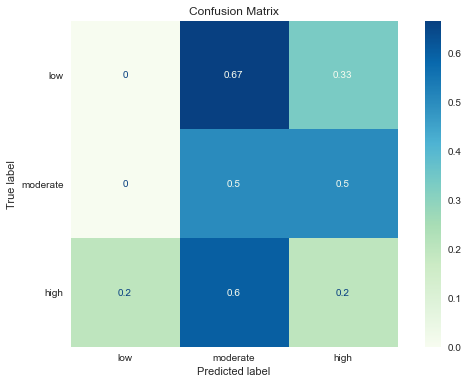

In [46]:
tree_baseline = DecisionTreeClassifier(random_state=5)
run_model(tree_baseline, X_train, y_train, X_test, y_test)

Our testing results are very weak compared to a training accuracy of 100%. The model has overfit to the training data. We will use grid search to try to improve our testing results.

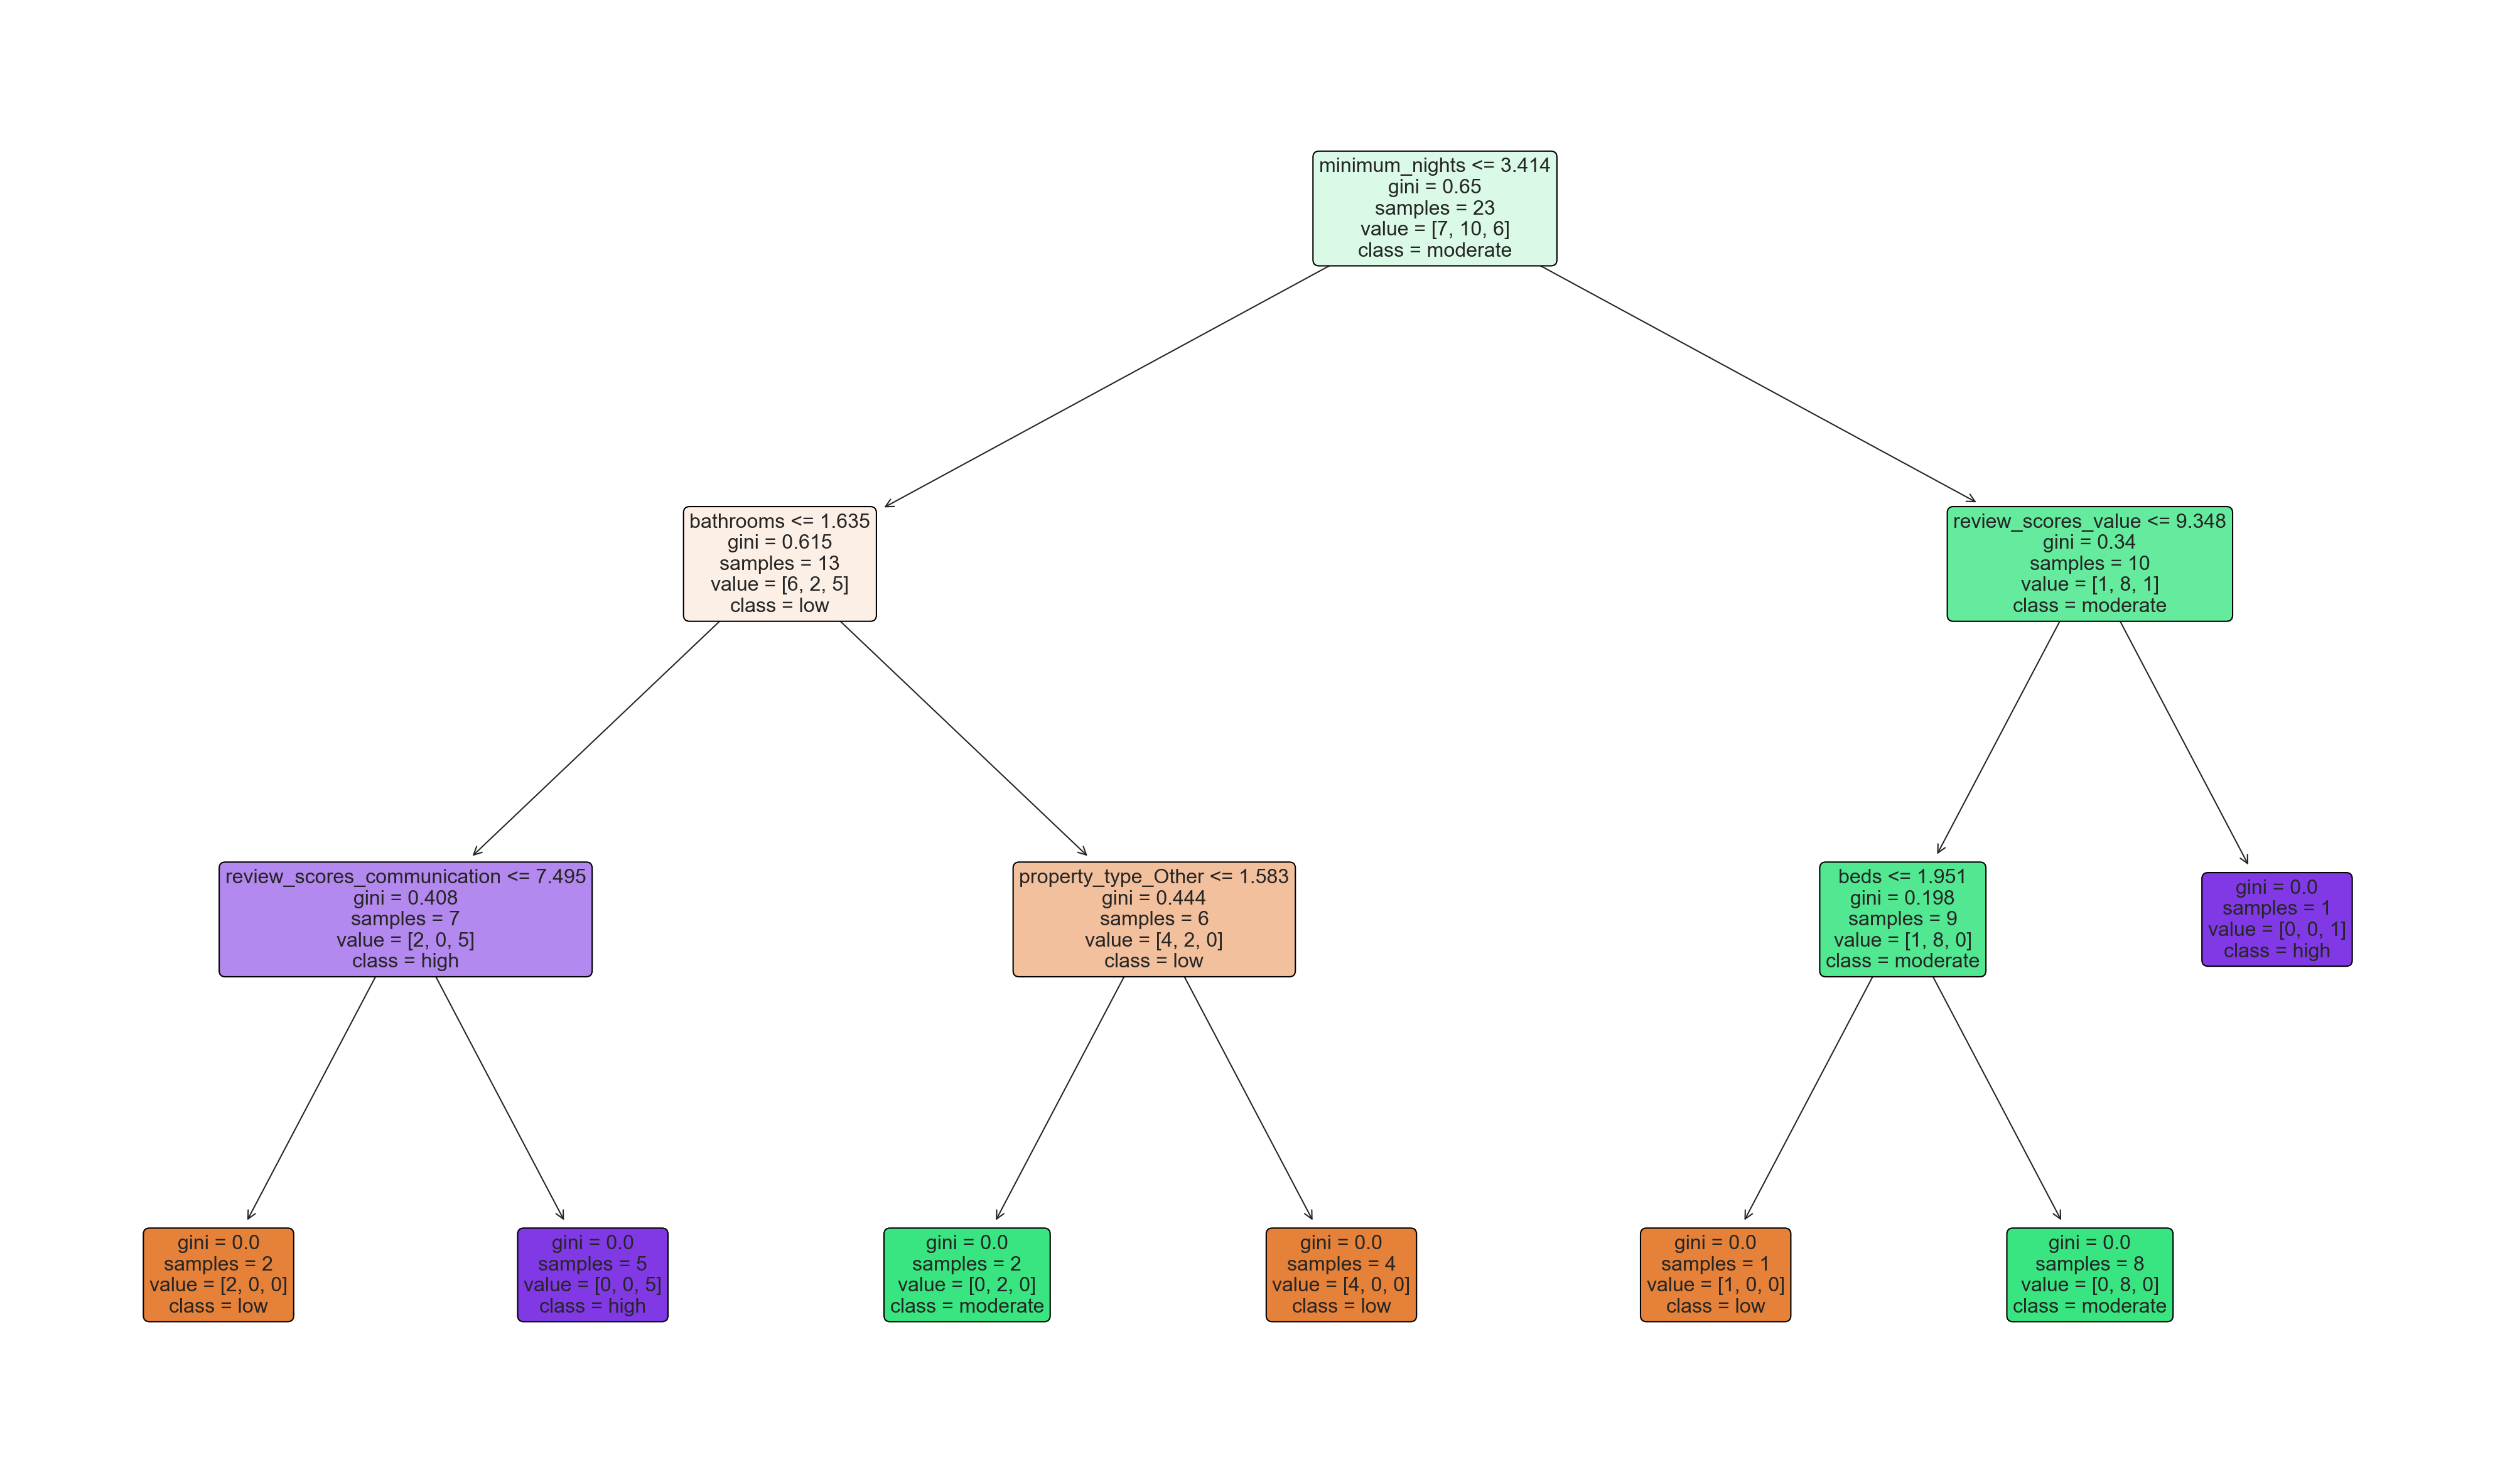

In [47]:
# visualize which features are used to determine growth category in tree
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (10,6), dpi=500)
plot_tree(tree_baseline,
          feature_names = X.columns, 
          class_names = class_names,
          filled = True, rounded=True)
plt.show()

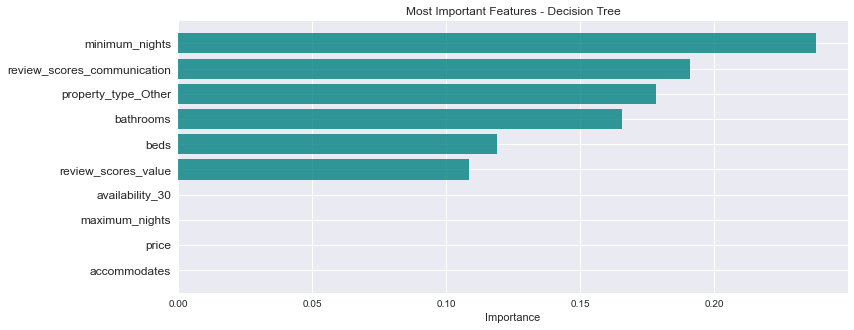

In [48]:
# visualize which features are most important to determining classification
plot_top_10_features(tree_baseline, 'Decision Tree')

### Grid Search

In [49]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,5,10],
    'min_samples_split': [5,10,20],
    'min_samples_leaf': [0.1, 0.3, 0.5]
}

grid_tree = GridSearchCV(tree_baseline, param_grid, cv=3)
grid_tree.fit(X_train, y_train)

grid_tree.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 0.1,
 'min_samples_split': 20}

Training accuracy score: 0.61
              precision    recall  f1-score   support

         low       0.29      0.67      0.40         3
    moderate       0.00      0.00      0.00         2
        high       0.00      0.00      0.00         5

    accuracy                           0.20        10
   macro avg       0.10      0.22      0.13        10
weighted avg       0.09      0.20      0.12        10



{'precision': 0.09, 'recall': 0.2, 'accuracy': 0.2, 'f1': 0.12}

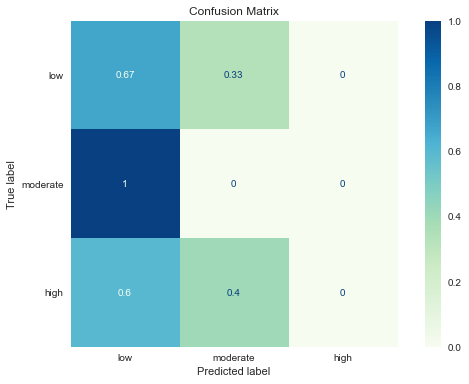

In [50]:
new_tree = DecisionTreeClassifier(criterion = grid_tree.best_params_['criterion'], 
                                   max_depth = grid_tree.best_params_['max_depth'], 
                                   min_samples_split = grid_tree.best_params_['min_samples_split'],
                                   min_samples_leaf = grid_tree.best_params_['min_samples_leaf'],
                                 random_state=5)
run_model(new_tree, X_train, y_train, X_test, y_test)

We were not able to improve our testing results. Let's try using a different algorithm.

## Random Forest Model

Training accuracy score: 1.0
              precision    recall  f1-score   support

         low       0.33      0.33      0.33         3
    moderate       0.20      0.50      0.29         2
        high       0.50      0.20      0.29         5

    accuracy                           0.30        10
   macro avg       0.34      0.34      0.30        10
weighted avg       0.39      0.30      0.30        10



{'precision': 0.39, 'recall': 0.3, 'accuracy': 0.3, 'f1': 0.3}

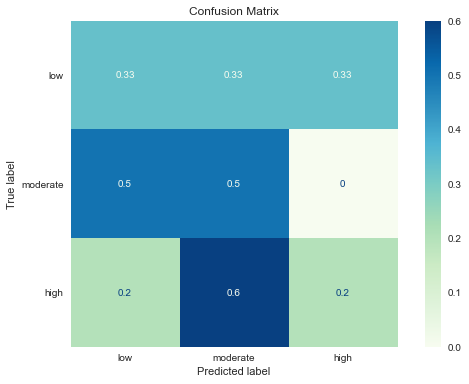

In [51]:
forest = RandomForestClassifier(random_state=8)
run_model(forest, X_train, y_train, X_test, y_test)

We are already achieving better results using a random forest classifier. Let's see if we can improve our testing results further using gridsearch.

### Grid Search

In [52]:
rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [3,5,10],
    'min_samples_split': [5,10,20],
    'max_features': [5,10,15]
}

In [53]:
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 47.62%

Optimal Parameters: {'max_depth': 3, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 100}


In [54]:
forest_2 = RandomForestClassifier(n_estimators=100,
                                 max_features=rf_grid_search.best_params_['max_features'], 
                                 max_depth=rf_grid_search.best_params_['max_depth'],
                                 min_samples_split=rf_grid_search.best_params_['min_samples_split'],
                                 random_state=9)

Training accuracy score: 1.0
              precision    recall  f1-score   support

         low       0.50      0.33      0.40         3
    moderate       0.20      0.50      0.29         2
        high       1.00      0.60      0.75         5

    accuracy                           0.50        10
   macro avg       0.57      0.48      0.48        10
weighted avg       0.69      0.50      0.55        10



{'precision': 0.69, 'recall': 0.5, 'accuracy': 0.5, 'f1': 0.55}

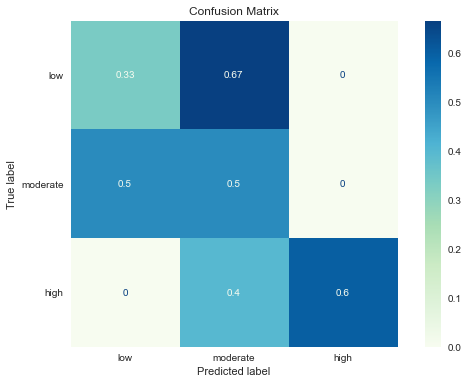

In [55]:
run_model(forest_2, X_train, y_train, X_test, y_test)

Our model is still extremely overfit and has very low testing scores.

## Logistic Regression

In [56]:
logreg = LogisticRegression(C=1e12, random_state=22)

Training accuracy score: 0.83
              precision    recall  f1-score   support

         low       0.00      0.00      0.00         3
    moderate       0.00      0.00      0.00         2
        high       0.50      0.40      0.44         5

    accuracy                           0.20        10
   macro avg       0.17      0.13      0.15        10
weighted avg       0.25      0.20      0.22        10



{'precision': 0.25, 'recall': 0.2, 'accuracy': 0.2, 'f1': 0.22}

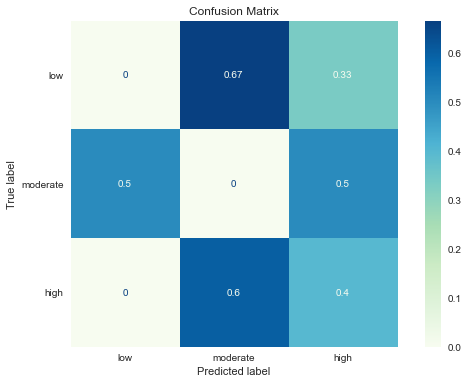

In [57]:
run_model(logreg, X_train, y_train, X_test, y_test)

Let's try running the logistic regression model with a balanced class_weight parameter.

In [58]:
logreg2 = LogisticRegression(C=1e12, random_state=22, class_weight='balanced')

Training accuracy score: 0.83
              precision    recall  f1-score   support

         low       0.50      0.33      0.40         3
    moderate       0.00      0.00      0.00         2
        high       0.50      0.40      0.44         5

    accuracy                           0.30        10
   macro avg       0.33      0.24      0.28        10
weighted avg       0.40      0.30      0.34        10



{'precision': 0.4, 'recall': 0.3, 'accuracy': 0.3, 'f1': 0.34}

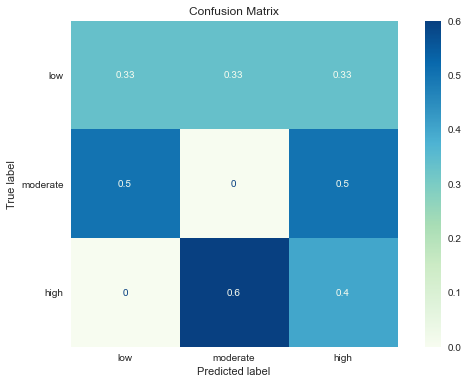

In [59]:
run_model(logreg2, X_train, y_train, X_test, y_test)

We are not able to achieve very strong results with these models. This is likely due to the fact we have very few data points available for both our training and testing dataset. We are going to try answering a different question with our classification models.

# Question: Can we predict whether or not an airbnb will be highly available?

## Prepare Data

### Pull in current listings dataframe

In [60]:
current_listings_df = pd.read_csv("cleaned_data/current_listing_availability.csv", index_col=0)

In [61]:
current_listings_df.head()

last_scraped      id  host_id  host_is_superhost  zipcode  latitude  \
0   2021-02-20    6422    12172                  1  37206.0  36.17315   
1   2021-02-20   25613    95811                  1  37206.0  36.17826   
2   2021-02-20  136015   666322                  0  37214.0  36.19464   
3   2021-02-20  258817    22296                  1  37076.0  36.16249   
4   2021-02-20  289242    22296                  1  37076.0  36.16102   

   longitude  accommodates  bathrooms  beds  ...  neighborhood_East_Nashville  \
0  -86.73581             2        1.0   3.0  ...                            1   
1  -86.74162             2        1.0   1.0  ...                            1   
2  -86.67195             2        1.0   1.0  ...                            0   
3  -86.58988             2        1.0   2.0  ...                            0   
4  -86.59207             1        1.0   3.0  ...                            0   

   neighborhood_Madison  neighborhood_Midtown  neighborhood_North_Nashville  \
0                     0                     0                             0   
1                     0                     0                             0   
2                     0                     0                             0   
3                     0                     0                             0   
4                     0                     0                             0   

   neighborhood_Parkwood  neighborhood_South_Nashville  \
0                      0                             0   
1                      0                             0   
2                      0                             0   
3                      0                             0   
4                      0                             0   

   neighborhood_Southeast_Nashville  neighborhood_West_Nashville  \
0                                 0                            0   
1                                 0                            0   
2                                 0                            0   
3                                 0                            0   
4                                 0                            0   

   neighborhood_Whites_Creek  available  
0                          0        217  
1                          0         21  
2                          0        140  
3                          0        314  
4                          0        314  

[5 rows x 50 columns]

### Decide on threshold for 'highly available'

In [62]:
current_listings_df['available'].describe()

count    6137.000000
mean      174.681766
std       111.609185
min         0.000000
25%        74.000000
50%       197.000000
75%       277.000000
max       316.000000
Name: available, dtype: float64

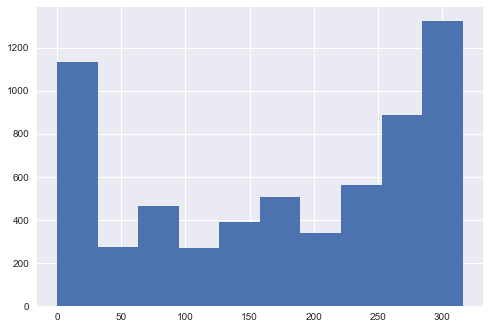

In [63]:
current_listings_df['available'].hist()

We are going to consider any availability greater than 90 days as highly available, because if a property is available more days per year than that, it is likely the owner does not live there.

In [64]:
def convert_availability(x):
    if x > 90:
        # return 1 which will stand for high availability
        return 1
    else:
        # return 0 which will stand for low availability
        return 0

In [65]:
current_listings_df['availability'] = current_listings_df['available'].apply(lambda x: convert_availability(x))

In [66]:
current_listings_df

last_scraped        id    host_id  host_is_superhost  zipcode  latitude  \
0      2021-02-20      6422      12172                  1  37206.0  36.17315   
1      2021-02-20     25613      95811                  1  37206.0  36.17826   
2      2021-02-20    136015     666322                  0  37214.0  36.19464   
3      2021-02-20    258817      22296                  1  37076.0  36.16249   
4      2021-02-20    289242      22296                  1  37076.0  36.16102   
...           ...       ...        ...                ...      ...       ...   
6132   2021-02-20  48207668  368944610                  0  37076.0  36.17157   
6133   2021-02-21  48208643  359230893                  0  37203.0  36.15664   
6134   2021-02-20  48211893  153902467                  0  37209.0  36.14538   
6135   2021-02-20  48224293  368944610                  0  37214.0  36.17812   
6136   2021-02-20  48226977   60934272                  0  37206.0  36.17324   

      longitude  accommodates  bathrooms  beds  ...  neighborhood_Madison  \
0     -86.73581             2        1.0   3.0  ...                     0   
1     -86.74162             2        1.0   1.0  ...                     0   
2     -86.67195             2        1.0   1.0  ...                     0   
3     -86.58988             2        1.0   2.0  ...                     0   
4     -86.59207             1        1.0   3.0  ...                     0   
...         ...           ...        ...   ...  ...                   ...   
6132  -86.59580             5        1.0   2.0  ...                     0   
6133  -86.79764             5        2.0   2.0  ...                     0   
6134  -86.82469             2        2.0   2.0  ...                     0   
6135  -86.64146             3        1.0   1.0  ...                     0   
6136  -86.76257             8        2.0   3.0  ...                     0   

      neighborhood_Midtown  neighborhood_North_Nashville  \
0                        0                             0   
1                        0                             0   
2                        0                             0   
3                        0                             0   
4                        0                             0   
...                    ...                           ...   
6132                     0                             0   
6133                     0                             1   
6134                     0                             0   
6135                     0                             0   
6136                     0                             0   

      neighborhood_Parkwood  neighborhood_South_Nashville  \
0                         0                             0   
1                         0                             0   
2                         0                             0   
3                         0                             0   
4                         0                             0   
...                     ...                           ...   
6132                      0                             0   
6133                      0                             0   
6134                      0                             0   
6135                      0                             0   
6136                      0                             0   

      neighborhood_Southeast_Nashville  neighborhood_West_Nashville  \
0                                    0                            0   
1                                    0                            0   
2                                    0                            0   
3                                    0                            0   
4                                    0                            0   
...                                ...                          ...   
6132                                 0                            0   
6133                                 0                            0   
6134                      

In [67]:
availability_class = current_listings_df.availability.map({1:'High',0:'Low'})
availability_class

0       High
1        Low
2       High
3       High
4       High
        ... 
6132    High
6133    High
6134    High
6135    High
6136    High
Name: availability, Length: 6137, dtype: object

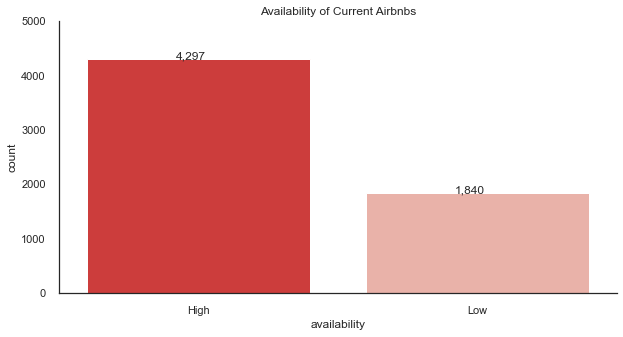

In [68]:
colors = ['#E42524', '#F4AA9E', '#008D8A', '#E3F9F7']

sns.set_palette(sns.color_palette(colors))
sns.set_context('notebook')
sns.set_style('white')

plt.figure(figsize=(10,5))
ax = sns.countplot(x=availability_class)
ax.set_title('Availability of Current Airbnbs')
ax.set(ylim=(0, 5000))

for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = p.get_x()+(width/2.5),
            y = height+.01,
            s = '{:,.0f}'.format(height)) 

sns.despine()
plt.savefig('images/avail_classes.png')

We need to keep in mind when modeling that there is a class imbalance for the availability target.

### Select Feature Columns

Since this classifier is going to be used to predict whether or not a new listing will be highly available, we need to only use features that would be available for a new listing. This would include physical features of the house and the house's location.

In [69]:
current_listings_df.columns

Index(['last_scraped', 'id', 'host_id', 'host_is_superhost', 'zipcode',
       'latitude', 'longitude', 'accommodates', 'bathrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count', 'occ_rate', 'monthly_income',
       'multi_listing_host', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_House',
       'property_type_Other', 'property_type_Townhouse',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'neighborhood_Bellevue',
       'neighborhood_Donelson', 'neighborhood_Downtown',
       'neighborhood_East_Nashville', 'neighborhood_Madison',
       'neig

In [70]:
current_listings_model_data = current_listings_df[['accommodates','bathrooms','beds','price','instant_bookable','property_type_Guest suite',
                                                   'property_type_Condominium', 'property_type_House','property_type_Other',
                                                   'property_type_Townhouse','room_type_Hotel room', 'room_type_Private room',
                                                   'room_type_Shared room', 'neighborhood_Bellevue','neighborhood_Donelson',
                                                   'neighborhood_Downtown','neighborhood_East_Nashville',
                                                   'neighborhood_Madison','neighborhood_Midtown',
                                                   'neighborhood_North_Nashville', 'neighborhood_Parkwood',
                                                   'neighborhood_South_Nashville','neighborhood_Southeast_Nashville',
                                                   'neighborhood_West_Nashville','neighborhood_Whites_Creek','availability']]

In [71]:
y = current_listings_model_data['availability']
X = current_listings_model_data.drop(columns=['availability'])

In [72]:
class_names = np.array(['low','high'])

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=35)

## K-Nearest Neighbors

### Normalize Data

In [74]:
# Instantiate StandardScaler--KNN requires all inputs be on the same scale
scaler = StandardScaler()

# Transform the training and test sets
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [75]:
# Instantiate KNeighborsClassifier
knn_clf = KNeighborsClassifier()

Training accuracy score: 0.8
              precision    recall  f1-score   support

         low       0.50      0.40      0.44       544
        high       0.77      0.83      0.80      1298

    accuracy                           0.70      1842
   macro avg       0.63      0.62      0.62      1842
weighted avg       0.69      0.70      0.69      1842



{'precision': 0.69, 'recall': 0.7, 'accuracy': 0.7, 'f1': 0.69}

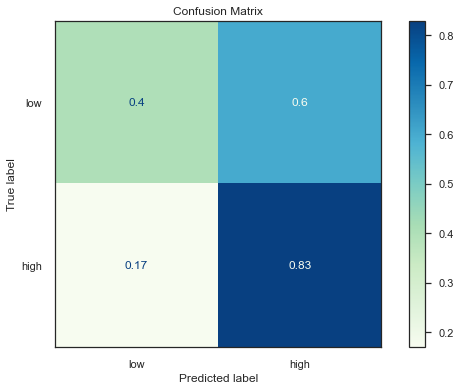

In [76]:
run_model(knn_clf, scaled_X_train, y_train, scaled_X_test, y_test)

Our training accuracy is slightly higher than our testing accuracy. The model is also classifying most of the low availability homes as high availability homes. Let's see if we can improve this using grid search.

### Grid Search

In [77]:
knn_param_grid = {
    'n_neighbors': [3,5,11,15,25],
    'metric': ['minkowski','euclidean','manhattan']
}

In [78]:
knn_grid_search = GridSearchCV(knn_clf, knn_param_grid, scoring='accuracy', cv=3)
knn_grid_search.fit(scaled_X_train, y_train)

print(f"Testing Accuracy: {knn_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {knn_grid_search.best_params_}")

Testing Accuracy: 71.46%

Optimal Parameters: {'metric': 'minkowski', 'n_neighbors': 25}


In [79]:
knn_2 = KNeighborsClassifier(n_neighbors=knn_grid_search.best_params_['n_neighbors'], 
                             metric=knn_grid_search.best_params_['metric'])

Training accuracy score: 0.74
              precision    recall  f1-score   support

         low       0.59      0.28      0.38       544
        high       0.75      0.92      0.83      1298

    accuracy                           0.73      1842
   macro avg       0.67      0.60      0.60      1842
weighted avg       0.70      0.73      0.69      1842



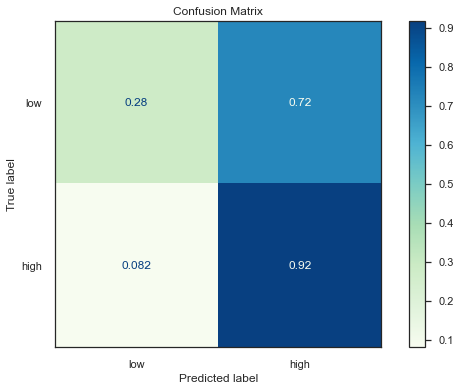

In [80]:
knn_scores = run_model(knn_2, scaled_X_train, y_train, scaled_X_test, y_test)

Although we weren't able to improve the classifying of our low class, we were able to achieve training and testing accuracy very close to each other.

### Cross Validate

In [81]:
knn_cv_scores = cross_val_classifier(knn_2, scaled_X_train, y_train, cv=5)

In [82]:
print(knn_cv_scores)

{'fit_time': 0.0028005599975585937, 'score_time': 0.1645143985748291, 'test_accuracy': 0.7166472642607684, 'train_accuracy': 0.7362630966239814, 'test_precision': 0.7403531529544937, 'train_precision': 0.7510342958412242, 'test_recall': 0.9153016138007791, 'train_recall': 0.9308937751841044, 'test_f1': 0.8185493379115037, 'train_f1': 0.8313426759218437}


### Save Model

In [83]:
knn = knn_2.fit(scaled_X_train,y_train)

with open('knn.pickle','wb') as f:
    pickle.dump(knn, f)

## Random Forest Model

We will use a balanced class weight parameter in our random forest model to account for the class imbalance.

Training accuracy score: 0.99
              precision    recall  f1-score   support

         low       0.51      0.42      0.46       544
        high       0.78      0.83      0.80      1298

    accuracy                           0.71      1842
   macro avg       0.64      0.63      0.63      1842
weighted avg       0.70      0.71      0.70      1842



{'precision': 0.7, 'recall': 0.71, 'accuracy': 0.71, 'f1': 0.7}

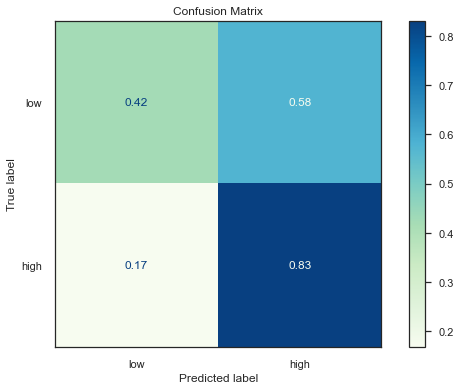

In [84]:
forest = RandomForestClassifier(class_weight='balanced',random_state=10)
run_model(forest, X_train, y_train, X_test, y_test)

The training set has performed much better than the testing set. We are also still seeing many of the low classes be misclassified. Let's see if we can improve these scores using grid search.

### Grid Search

In [85]:
rf_param_grid = {
    'n_estimators': [25,40,100],
    'max_depth': [3,5,10],
    'min_samples_split': [5,10,20],
    'max_features': [5,10,15],
    'class_weight':['balanced']
}

In [86]:
rf_grid_search = GridSearchCV(forest, rf_param_grid, scoring='accuracy', cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 69.57%

Optimal Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 15, 'min_samples_split': 5, 'n_estimators': 25}


In [87]:
forest_2 = RandomForestClassifier(n_estimators=rf_grid_search.best_params_['n_estimators'],
                                 max_features=rf_grid_search.best_params_['max_features'], 
                                 max_depth=rf_grid_search.best_params_['max_depth'],
                                 min_samples_split=rf_grid_search.best_params_['min_samples_split'],
                                 class_weight=rf_grid_search.best_params_['class_weight'],
                                 random_state=8)

Training accuracy score: 0.8
              precision    recall  f1-score   support

         low       0.46      0.57      0.51       544
        high       0.80      0.72      0.76      1298

    accuracy                           0.68      1842
   macro avg       0.63      0.65      0.63      1842
weighted avg       0.70      0.68      0.68      1842



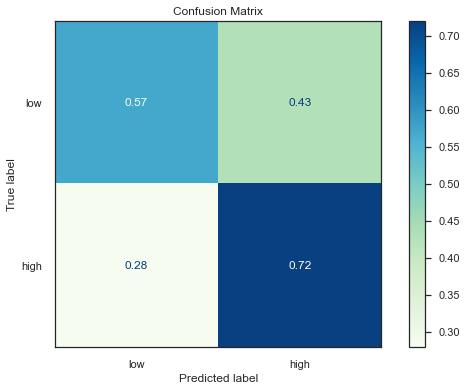

In [88]:
rf_scores = run_model(forest_2, X_train, y_train, X_test, y_test)

Although our scores may have not improved, our model is less overfit to the training data. The low availability homes are also being classified better.

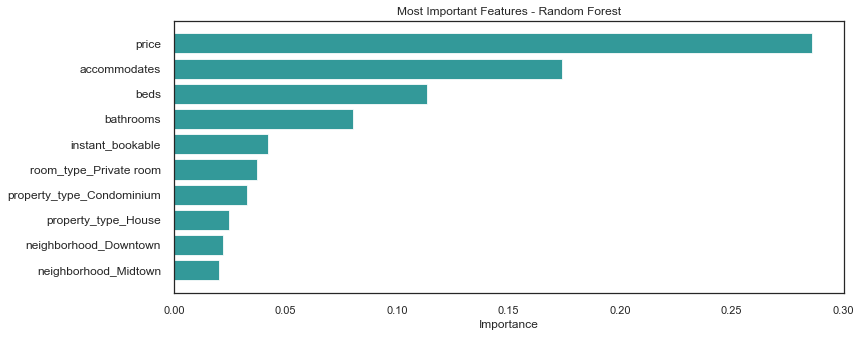

In [89]:
plot_top_10_features(forest_2, 'Random Forest')

### Cross Validate

In [90]:
rf_cv_scores = cross_val_classifier(forest_2, X_train, y_train, cv=5)

In [91]:
print(rf_cv_scores)

{'fit_time': 0.27399659156799316, 'score_time': 0.023002004623413085, 'test_accuracy': 0.6912689173457509, 'train_accuracy': 0.8097206053550641, 'test_precision': 0.8123674399745889, 'train_precision': 0.9134663336499379, 'test_recall': 0.7255765164162493, 'train_recall': 0.8035998680005557, 'test_f1': 0.7664511649312671, 'train_f1': 0.8549910321718753}


### Save Model

In [92]:
# save model

import pickle

rand_forest = forest_2.fit(X_train,y_train)

with open('random_forest.pickle','wb') as f:
    pickle.dump(rand_forest, f)

## Gradient Boosting Model

Training accuracy score: 0.76
              precision    recall  f1-score   support

         low       0.59      0.20      0.30       544
        high       0.74      0.94      0.83      1298

    accuracy                           0.72      1842
   macro avg       0.66      0.57      0.56      1842
weighted avg       0.69      0.72      0.67      1842



{'precision': 0.69, 'recall': 0.72, 'accuracy': 0.72, 'f1': 0.67}

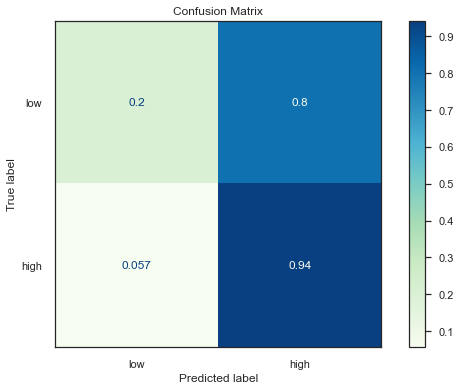

In [93]:
gbt_clf = GradientBoostingClassifier(random_state=42)
run_model(gbt_clf,X_train, y_train, X_test, y_test)

Since gradient boosting does not have a class weight parameter, let's try using SMOTE and see if we can help our model's ability to classify low availability homes.

In [94]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

Training accuracy score: 0.78
              precision    recall  f1-score   support

         low       0.44      0.49      0.46       544
        high       0.78      0.73      0.76      1298

    accuracy                           0.66      1842
   macro avg       0.61      0.61      0.61      1842
weighted avg       0.68      0.66      0.67      1842



{'precision': 0.68, 'recall': 0.66, 'accuracy': 0.66, 'f1': 0.67}

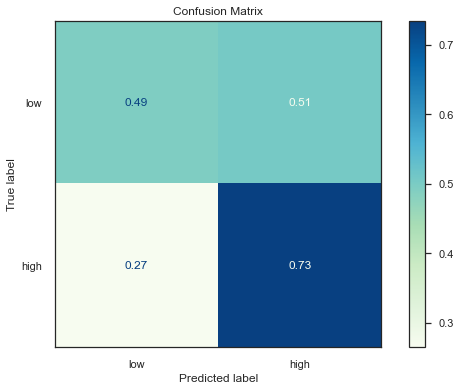

In [95]:
gbt_clf = GradientBoostingClassifier(random_state=42)
run_model(gbt_clf,X_train_resampled, y_train_resampled, X_test, y_test)

Although we lost some accuracy, using the SMOTE data leads to better results in our low availability class, so we will stick with this.

### GridSearch

In [96]:
gb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [3,6],
    'min_samples_split': [2,5],
    'n_estimators': [50,100],
}

In [97]:
gb_grid_search = GridSearchCV(gbt_clf, gb_param_grid, 
                               scoring='accuracy', cv=3)
gb_grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Testing Accuracy: {gb_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {gb_grid_search.best_params_}")

Testing Accuracy: 77.03%

Optimal Parameters: {'learning_rate': 0.2, 'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 100}


In [98]:
gb_clf_2 = GradientBoostingClassifier(learning_rate = gb_grid_search.best_params_['learning_rate'],
                          max_depth = gb_grid_search.best_params_['max_depth'],
                          min_samples_split = gb_grid_search.best_params_['min_samples_split'],
                          n_estimators = gb_grid_search.best_params_['n_estimators'],
                          random_state=7)

Training accuracy score: 0.92
              precision    recall  f1-score   support

         low       0.47      0.42      0.45       544
        high       0.77      0.80      0.78      1298

    accuracy                           0.69      1842
   macro avg       0.62      0.61      0.62      1842
weighted avg       0.68      0.69      0.68      1842



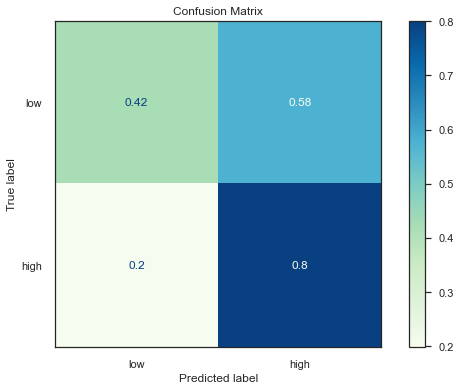

In [99]:
gb_scores = run_model(gb_clf_2,X_train_resampled, y_train_resampled, X_test, y_test)

The model has become more overfit to the training data.

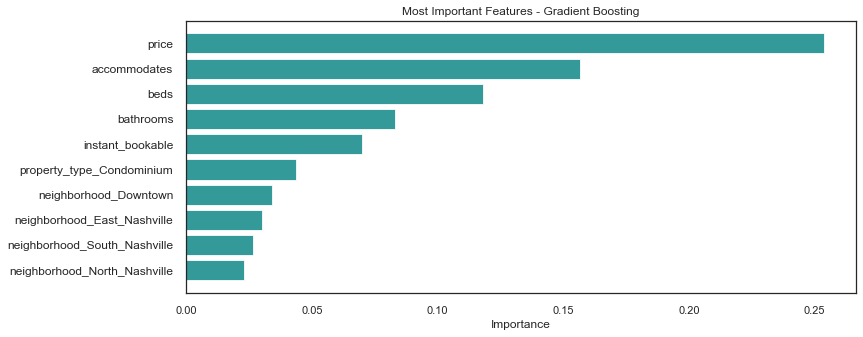

In [100]:
plot_top_10_features(gb_clf_2, 'Gradient Boosting')

### Cross Validate

In [101]:
gb_cv_scores = cross_val_classifier(gb_clf_2, X_train_resampled, y_train_resampled, cv=5)

In [102]:
print(gb_cv_scores)

{'fit_time': 1.8788006782531739, 'score_time': 0.01940631866455078, 'test_accuracy': 0.785129691409508, 'train_accuracy': 0.9306863985575708, 'test_precision': 0.8145781825874849, 'train_precision': 0.9203973139192424, 'test_recall': 0.8285982192543129, 'train_recall': 0.9428990898985689, 'test_f1': 0.8058934607824074, 'train_f1': 0.9315033610555105}


### Save Model

In [103]:
grad_boost = gb_clf_2.fit(X_train_resampled,y_train_resampled)

with open('gradient_boost.pickle','wb') as f:
    pickle.dump(grad_boost, f)

## XGBoost Model

Training accuracy score: 0.91
              precision    recall  f1-score   support

         low       0.49      0.42      0.45       544
        high       0.77      0.82      0.79      1298

    accuracy                           0.70      1842
   macro avg       0.63      0.62      0.62      1842
weighted avg       0.69      0.70      0.69      1842



{'precision': 0.69, 'recall': 0.7, 'accuracy': 0.7, 'f1': 0.69}

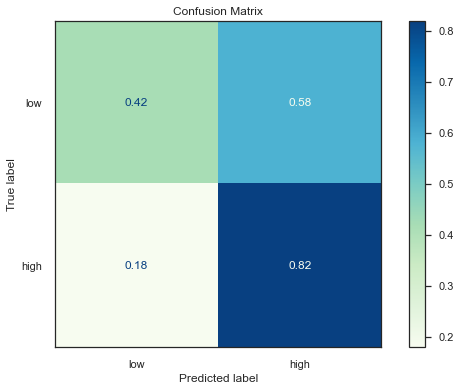

In [104]:
xgb_clf = XGBClassifier(objective ='binary:logistic', eval_metrics = 'error', verbosity= 0, random_state=47)
run_model(xgb_clf,X_train_resampled, y_train_resampled, X_test, y_test)

### GridSearch

In [105]:
xgb_param_grid = {
    'learning_rate': [0.3, 0.4],
    'max_depth': [4,5],
    'min_child_weight': [2,3],
    'subsample': [0.5, 0.7],
}

In [106]:
warnings.filterwarnings("ignore")

xgb_grid_search = GridSearchCV(xgb_clf, xgb_param_grid, 
                               scoring='accuracy', cv=3, n_jobs=1)
xgb_grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Testing Accuracy: {xgb_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {xgb_grid_search.best_params_}")

Testing Accuracy: 76.46%

Optimal Parameters: {'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.7}


In [107]:
xgb_clf_2 = XGBClassifier(learning_rate = xgb_grid_search.best_params_['learning_rate'],
                          max_depth = xgb_grid_search.best_params_['max_depth'],
                          min_child_weight = xgb_grid_search.best_params_['min_child_weight'],
                          subsample = xgb_grid_search.best_params_['subsample'],
                          objective = 'binary:logistic', eval_metrics = 'error', verbosity= 0,
                          random_state=65)

Training accuracy score: 0.87
              precision    recall  f1-score   support

         low       0.49      0.43      0.46       544
        high       0.77      0.81      0.79      1298

    accuracy                           0.70      1842
   macro avg       0.63      0.62      0.63      1842
weighted avg       0.69      0.70      0.69      1842



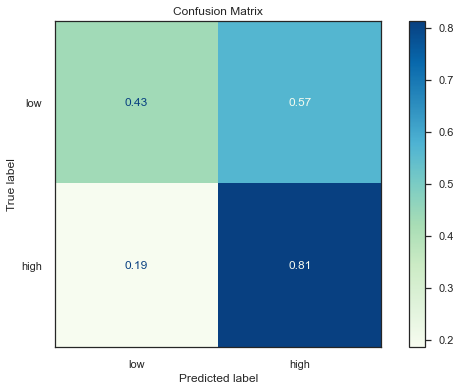

In [108]:
xgb_scores = run_model(xgb_clf_2,X_train_resampled, y_train_resampled, X_test, y_test)

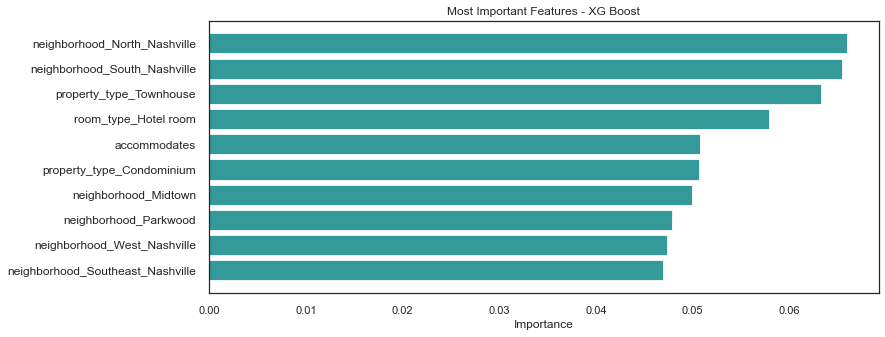

In [109]:
plot_top_10_features(xgb_clf_2, "XG Boost")

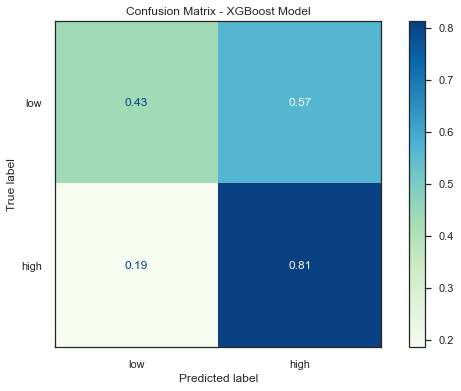

In [110]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrix - XGBoost Model')
disp = plot_confusion_matrix(xgb_clf_2, X_test, y_test, ax = ax,
                                 display_labels = class_names,
                                 normalize='true', cmap='GnBu')
plt.grid(False)
plt.savefig('images/conf_matrix.png')

### Cross Validate

In [111]:
xgb_cv_scores = cross_val_classifier(xgb_clf_2, X_train_resampled, y_train_resampled, cv=5)

In [112]:
print(xgb_cv_scores)

{'fit_time': 0.22679448127746582, 'score_time': 0.009600114822387696, 'test_accuracy': 0.778964553794829, 'train_accuracy': 0.8811283631151099, 'test_precision': 0.8088435385443044, 'train_precision': 0.8626784152102301, 'test_recall': 0.8246015581524764, 'train_recall': 0.9063870362651105, 'test_f1': 0.8011396222065841, 'train_f1': 0.8839717977459991}


### Save Model

In [113]:
xg_boost = xgb_clf_2.fit(X_train_resampled,y_train_resampled)

with open('xg_boost.pickle','wb') as f:
    pickle.dump(xg_boost, f)

# Compare Models

In [114]:
all_scores_df = pd.DataFrame([knn_cv_scores, rf_cv_scores, gb_cv_scores, xgb_cv_scores])

all_scores_df.loc[0 ,'model'] = 'KNN'
all_scores_df.loc[1 ,'model'] = 'Random Forest'
all_scores_df.loc[2 ,'model'] = 'Gradient Boosting'
all_scores_df.loc[3 ,'model'] = 'XGBoost'

all_scores_df

fit_time  score_time  test_accuracy  train_accuracy  test_precision  \
0  0.002801    0.164514       0.716647        0.736263        0.740353   
1  0.273997    0.023002       0.691269        0.809721        0.812367   
2  1.878801    0.019406       0.785130        0.930686        0.814578   
3  0.226794    0.009600       0.778965        0.881128        0.808844   

   train_precision  test_recall  train_recall   test_f1  train_f1  \
0         0.751034     0.915302      0.930894  0.818549  0.831343   
1         0.913466     0.725577      0.803600  0.766451  0.854991   
2         0.920397     0.828598      0.942899  0.805893  0.931503   
3         0.862678     0.824602      0.906387  0.801140  0.883972   

               model  
0                KNN  
1      Random Forest  
2  Gradient Boosting  
3            XGBoost

In [115]:
fig = go.Figure(data=[
    go.Bar(name='Test Accuracy', x=all_scores_df.model, y=all_scores_df.test_accuracy),
    go.Bar(name='Train Accuracy', x=all_scores_df.model, y=all_scores_df.train_accuracy)
])
# Change the bar mode
fig.update_layout(barmode='group',width=800,height=325)
fig.show()

Accuracy measures what percentage of our total predictions were correct.

In [116]:
fig = go.Figure(data=[
    go.Bar(name='Test Precision', x=all_scores_df.model, y=all_scores_df.test_precision),
    go.Bar(name='Train Precision', x=all_scores_df.model, y=all_scores_df.train_precision)
])
# Change the bar mode
fig.update_layout(barmode='group',width=800,height=325)
fig.show()

Precision measures the percentage of true positives out of all predicted positives.

In [117]:
fig = go.Figure(data=[
    go.Bar(name='Test Recall', x=all_scores_df.model, y=all_scores_df.test_recall),
    go.Bar(name='Train Recall', x=all_scores_df.model, y=all_scores_df.train_recall)
])
# Change the bar mode
fig.update_layout(barmode='group',width=800,height=325)
fig.show()

Recall measures the percentage of true positives out of all actual positives. 

It appears the K-nearest neighbors model has the least amount of overfitting, although the accuracy and precision of the gradient boosting and XG Boost models are significantly higher. 

In [118]:
fig = go.Figure(data=[
    go.Bar(name='Test Accuracy', x=all_scores_df.model, y=all_scores_df.test_accuracy),
    go.Bar(name='Test Precision', x=all_scores_df.model, y=all_scores_df.test_precision),
    go.Bar(name='Test Recall', x=all_scores_df.model, y=all_scores_df.test_recall),
    go.Bar(name='Test F1', x=all_scores_df.model, y=all_scores_df.test_f1)
])
# Change the bar mode
fig.update_layout(barmode='group', colorway=['#e42524', '#f4aa9e', '#008d8a', '#e3f9f7'],width=800,height=325)
fig.show()

Even though there is still some overfitting in our XGBoost model, it has less overfitting than the gradient boosting model with similar scores, so we will accept it as our best model.

In [119]:
xg_boost_scores = all_scores_df[all_scores_df['model']=='XGBoost']

In [120]:
xg_boost_scores.set_index('model', inplace=True)

In [121]:
fig = go.Figure(data=[
    go.Bar(name='Test Accuracy', x=xg_boost_scores.index, y=xg_boost_scores.test_accuracy, 
           text=round(xg_boost_scores.test_accuracy,2)),
    go.Bar(name='Test Precision', x=xg_boost_scores.index, y=xg_boost_scores.test_precision,
          text=round(xg_boost_scores.test_precision,2)),
    go.Bar(name='Test Recall', x=xg_boost_scores.index, y=xg_boost_scores.test_recall,
          text=round(xg_boost_scores.test_recall,2)),
    go.Bar(name='Test F1', x=xg_boost_scores.index, y=xg_boost_scores.test_f1,
          text=round(xg_boost_scores.test_f1,2))
])
# Change the bar mode
fig.update_traces(textposition='outside')
fig.update_layout(title='XGBoost Model Evaluation Metrics', colorway=['#e42524', '#f4aa9e', '#008d8a', '#e3f9f7'],
                 width=900, height=500)
fig.show()

In [122]:
boost_scores = xg_boost_scores.T
boost_scores.drop(['fit_time','score_time','train_accuracy','train_precision', 
                   'train_recall', 'train_f1'], axis=0, inplace=True)

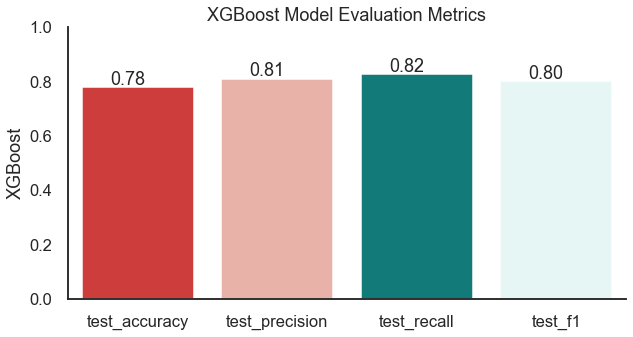

In [123]:
colors = ['#E42524', '#F4AA9E', '#008D8A', '#E3F9F7']

sns.set_palette(sns.color_palette(colors))
sns.set_context('talk')
sns.set_style('white')

plt.figure(figsize=(10,5))
ax = sns.barplot(x = boost_scores.index, y = boost_scores['XGBoost'], 
            data=boost_scores)
ax.set_title('XGBoost Model Evaluation Metrics')
ax.set(ylim=(0, 1))

for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = p.get_x()+(width/4),
            y = height+.01,
            s = '{:.2f}'.format(height)) 
sns.despine()

In [124]:
all_scores_df.set_index('model', inplace=True)

all_scores_df.to_csv("cleaned_data/class_model_scores.csv")

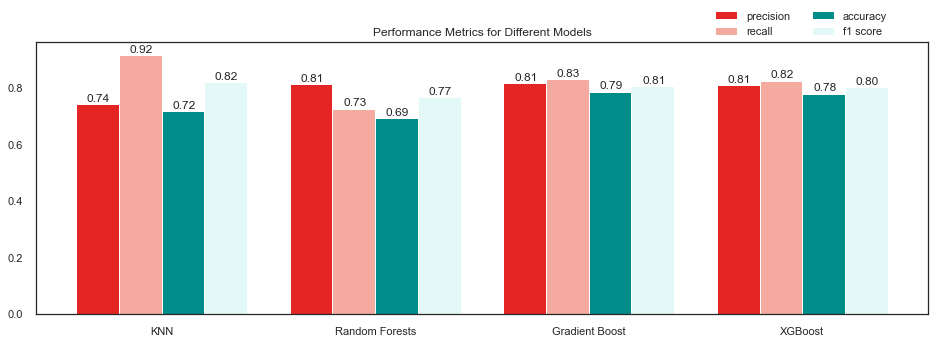

In [125]:
sns.set_context('notebook')
plt.figure(figsize=(16, 5))

ax = plt.subplot(111)

models = ['KNN', 
          'Random Forests',  'Gradient Boost', 'XGBoost']

values = [knn_cv_scores['test_precision'], rf_cv_scores['test_precision'], 
         gb_cv_scores['test_precision'], xgb_cv_scores['test_precision']]

model = np.arange(len(models))

plt.bar(model-.3, values, align='center', width=0.2, label='precision')

plt.xticks(model, models)

ax = plt.subplot(111)

models = ['KNN',
          'Random Forests', 'Gradient Boost', 'XGBoost']

values = [knn_cv_scores['test_recall'], rf_cv_scores['test_recall'], 
         gb_cv_scores['test_recall'], xgb_cv_scores['test_recall']]

model = np.arange(len(models))

plt.bar(model-.1, values, align='center', width=0.2, label='recall')

plt.xticks(model, models)

ax = plt.subplot(111)

models = ['KNN',  
          'Random Forests', 'Gradient Boost', 'XGBoost']

values = [knn_cv_scores['test_accuracy'], rf_cv_scores['test_accuracy'], 
         gb_cv_scores['test_accuracy'], xgb_cv_scores['test_accuracy']]

model = np.arange(len(models))

plt.bar(model+.1, values, align='center', width=0.2, label='accuracy')

plt.xticks(model, models)


ax = plt.subplot(111)

models = ['KNN',  
          'Random Forests', 'Gradient Boost', 'XGBoost']

values = [knn_cv_scores['test_f1'], rf_cv_scores['test_f1'], 
         gb_cv_scores['test_f1'], xgb_cv_scores['test_f1']]

model = np.arange(len(models))

plt.bar(model+.3, values, align='center', width=0.2, label='f1 score')

plt.xticks(model, models)

plt.title("Performance Metrics for Different Models")

ax.legend(loc="upper left", bbox_to_anchor=(.75, 1.15), ncol=2)

for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = p.get_x() + width/4, 
            y = (height+.01),
            s = '{:.2f}'.format(height))

plt.savefig('images/class_metrics.png')

# Make Prediction Function

In [126]:
X_train.columns

Index(['accommodates', 'bathrooms', 'beds', 'price', 'instant_bookable',
       'property_type_Guest suite', 'property_type_Condominium',
       'property_type_House', 'property_type_Other', 'property_type_Townhouse',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'neighborhood_Bellevue',
       'neighborhood_Donelson', 'neighborhood_Downtown',
       'neighborhood_East_Nashville', 'neighborhood_Madison',
       'neighborhood_Midtown', 'neighborhood_North_Nashville',
       'neighborhood_Parkwood', 'neighborhood_South_Nashville',
       'neighborhood_Southeast_Nashville', 'neighborhood_West_Nashville',
       'neighborhood_Whites_Creek'],
      dtype='object')

In [127]:
def make_prediction(clf, property_type, room_type, neighborhood, price, 
                    accommodates=2,bathrooms=2, beds=2, instant_bookable=1):
    true_prop_value = f'property_type_{property_type}'
    true_room_value = f'room_type_{room_type}'
    true_hood_value = f'neighborhood_{neighborhood}'
    list_of_values = []
    list_of_values.extend([accommodates, bathrooms, beds, price, instant_bookable])
    
    property_cols = ['property_type_Condominium', 'property_type_House',
                     'property_type_Other', 'property_type_Townhouse','property_type_Guest suite']
    property_values = []
    for col in property_cols:
        if true_prop_value == col:
            property_values.append(1)
        else:
            property_values.append(0)
    
    list_of_values.extend(property_values)
    
    room_cols = ['room_type_Hotel room','room_type_Private room','room_type_Shared room']
    
    room_values = []
    for col in room_cols:
        if true_room_value == col:
            room_values.append(1)
        else:
            room_values.append(0)
    
    list_of_values.extend(room_values)
    
    
    neighborhood_cols = ['neighborhood_Bellevue','neighborhood_Donelson', 'neighborhood_Downtown',
                         'neighborhood_East_Nashville', 'neighborhood_Madison',
                         'neighborhood_Midtown', 'neighborhood_North_Nashville',
                         'neighborhood_Parkwood', 'neighborhood_South_Nashville',
                         'neighborhood_Southeast_Nashville', 'neighborhood_West_Nashville',
                         'neighborhood_Whites_Creek']
    
    neighborhood_values = []
    for col in neighborhood_cols:
        if true_hood_value == col:
            neighborhood_values.append(1)
        else:
            neighborhood_values.append(0)
    
    list_of_values.extend(neighborhood_values)
    
    df = pd.DataFrame(list_of_values)
    df = df.T
    df.columns = X_train.columns
    
    X = df
    
    y_hat = clf.predict(X)
    
    if y_hat ==1:
        return 'REJECT AIRBNB APPLICATION'
    else:
        return 'ACCEPT AIRBNB APPLICATION'

In [128]:
make_prediction(xg_boost, property_type='House', room_type='Private room', neighborhood='Bellevue', price=95, 
                    accommodates=2,bathrooms=2, beds=2, instant_bookable=1)

'REJECT AIRBNB APPLICATION'

# Save Training and Testing Set

In [129]:
X_train.to_csv("cleaned_data/X_train_data.csv")
y_train.to_csv("cleaned_data/y_train_data.csv")
X_test.to_csv("cleaned_data/X_test_data.csv")
y_test.to_csv("cleaned_data/y_test_data.csv")
# X_train_resampled.to_csv("cleaned_data/X_train_resampled_data.csv")
# y_train_resampled.to_csv("cleaned_data/y_train_resampled_data.csv")